In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlx.core as mx
import mlx.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score
from utils import *
import os
from pathlib import Path
from utils import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
#pd.set_option('display.float_format', '{:.1e}'.format) 

# Aplicar el formato de notación científica a la columna 'A'
df = pd.read_csv("results_df.csv", index_col=False)

columnas_numericas = [
    'Accuracy Entrenamiento', 'Accuracy Validación', 'Accuracy Test',
    'EC Entrenamiento', 'EC Validación', 'EC Testeo',
    'ECN Entrenamiento', 'ECN Validación', 'ECN Testeo'
]

for columna in columnas_numericas:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')

df['Learning rate'] = df['Learning rate'].apply(lambda x: '{:.1e}'.format(x))
df['Accuracy Test'] = df['Accuracy Test'].astype(float)
df['Accuracy Validación'] = df['Accuracy Validación'].astype(float)
df['Accuracy Entrenamiento'] = df['Accuracy Entrenamiento'].astype(float)

#pd.set_option('display.max_colwidth', 20) # Máximo ancho de las columnas
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)

# Establecer la opción para mostrar los números de punto flotante con dos decimales
def format_floats(x):
    return '{:.2f}'.format(x) if isinstance(x, float) else x


# Ordenar el DataFrame por la columna 'Edad'
df = df.sort_values(by='Accuracy Validación', ascending=False)

for set in ["Entrenamiento","Validación", "Test"]:
    # Convertir la columna 'accuracy test' a tipo float
    df[f'Accuracy {set}'] = df[f'Accuracy {set}'].astype(float)
    # Eliminar los valores NaN de la columna 'accuracy test'
    df = df.dropna(subset=[f'Accuracy {set}'])
    df[f'Accuracy {set}'] = pd.to_numeric(df[f'Accuracy {set}'], errors='coerce')

for set in ["Entrenamiento","Validación", "Testeo"]:
    df[f'EC {set}'] = df[f'EC {set}'].astype(float)
    # Eliminar los valores NaN de la columna 'accuracy test'
    df = df.dropna(subset=[f'EC {set}'])
    df[f'EC {set}'] = pd.to_numeric(df[f'EC {set}'], errors='coerce')

# Calcular Error Rate básico para cada set
df['Error Rate Entrenamiento'] = 1 - df['Accuracy Entrenamiento']
df['Error Rate Validación'] = 1 - df['Accuracy Validación']
df['Error Rate Test'] = 1 - df['Accuracy Test']

# Definir los valores de max_error_train según la columna 'Dataset'
def calculate_max_error(row):
    if row['Dataset'] == 'socialiqa':
        return 0.33
    else:
        return 0.25

# Aplicar la función para obtener el valor de max_error_train personalizado
df['max_error_train'] = df.apply(calculate_max_error, axis=1)

# Calcular ERN usando la fórmula especificada y el max_error_train adecuado
df['TEN Entrenamiento'] = df['Error Rate Entrenamiento'] / (1 - df['max_error_train'])
df['TEN Validación'] = df['Error Rate Validación'] / (1 - df['max_error_train'].max())  # Usar el máximo global para validación
df['TEN Test'] = df['Error Rate Test'] / (1 - df['max_error_train'].max())  # Usar el máximo global para testeo



df_capas = df

# Aplicar el formato solo a las columnas de punto flotante
df_capas = df_capas.loc[df_capas['Iters'] != 1000]

df_iteraciones = df

#print(df.dtypes)
df.head(20)




,Empresa,Dataset,Modelo,Base/Fine-tuning,Capas LoRa,Tamaño batch,Learning rate,Iters,Adapter,Accuracy Entrenamiento,Accuracy Validación,Accuracy Test,EC Entrenamiento,EC Validación,EC Testeo,ECN Entrenamiento,ECN Validación,ECN Testeo,Error Rate Entrenamiento,Error Rate Validación,Error Rate Test,max_error_train,TEN Entrenamiento,TEN Validación,TEN Test
20,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-05,5000.0,Best,0.820200,0.820000,0.726667,0.404494,0.439014,0.599919,0.368318,0.399943,0.546088,0.179800,0.180000,0.273333,0.33,0.268358,0.268657,0.407960
19,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-05,10000.0,Best,0.736200,0.816667,0.722051,0.613033,0.429230,0.606679,0.558206,0.391030,0.552242,0.263800,0.183333,0.277949,0.33,0.393731,0.273632,0.414849
18,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-04,10000.0,Best,0.736200,0.806667,0.721026,0.613033,0.456506,0.610946,0.558206,0.415878,0.556126,0.263800,0.193333,0.278974,0.33,0.393731,0.288557,0.416380
23,microsoft,socialiqa,phi-2,Fine-tuning,24.0,5.0,1.0e-05,5000.0,Best,0.778600,0.790000,0.696410,0.514433,0.568511,0.710064,0.468425,0.517915,0.646349,0.221400,0.210000,0.303590,0.33,0.330448,0.313433,0.453119
21,microsoft,socialiqa,phi-2,Fine-tuning,8.0,5.0,1.0e-05,5000.0,Best,0.769000,0.770000,0.682051,0.497780,0.531790,0.676709,0.453261,0.484462,0.615987,0.231000,0.230000,0.317949,0.33,0.344776,0.343284,0.474550
4,microsoft,socialiqa,phi-1.5,Fine-tuning,8.0,4.0,1.0e-05,5000.0,Best,0.718000,0.726667,0.611282,0.619723,0.573570,0.801048,0.564201,0.522524,0.729169,0.282000,0.273333,0.388718,0.33,0.420896,0.407960,0.580176
25,microsoft,socialiqa,phi-2,Fine-tuning,2.0,5.0,1.0e-05,1000.0,Best,0.738400,0.726667,0.655897,0.618904,0.646047,0.799108,0.563552,0.588550,0.727403,0.261600,0.273333,0.344103,0.33,0.390448,0.407960,0.513586
17,microsoft,socialiqa,phi-2,Fine-tuning,20.0,5.0,1.0e-05,1000.0,Best,0.750400,0.723333,0.669231,0.561333,0.604268,0.745034,0.511130,0.550489,0.678182,0.249600,0.276667,0.330769,0.33,0.372537,0.412935,0.493685
24,microsoft,socialiqa,phi-2,Base,NaN,NaN,0.0e+00,NaN,NaN,0.736200,0.723333,0.667179,0.613033,0.647854,0.795405,0.558206,0.590197,0.724033,0.263800,0.276667,0.332821,0.33,0.393731,0.412935,0.496747
22,microsoft,socialiqa,phi-2,Fine-tuning,8.0,5.0,1.0e-05,1000.0,Best,0.734600,0.710000,0.656923,0.573680,0.603110,0.736992,0.522373,0.549434,0.670861,0.265400,0.290000,0.343077,0.33,0.396119,0.432836,0.512055


## Resultados

In [6]:
df_res = df.applymap(format_floats)

def filter_df(model, base_finetuned, dataset, df=df_res):# Correcting the filter criteria for the fine-tuned models
    
    df_filtered = df.dropna(subset=['Accuracy Validación', "Accuracy Test"])
    df_filtered.dropna(inplace=True)

    df_filtered = df_filtered[
        (df_filtered['Base/Fine-tuning'] == base_finetuned) & 
        (df_filtered['Modelo'] == model) & 
        (df_filtered['Dataset'] == dataset) ]

    df_sorted = df_filtered.sort_values(by='Accuracy Validación', ascending=False)
    accuracy_score = df_sorted.iloc[0]["Accuracy Test"]
    return accuracy_score


/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/4088683847.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_res = df.applymap(format_floats)


## Accuracy

In [7]:
# Example data
data = {
    'Modelo': ['phi-1.5 - Base', 'phi-1.5 - Fine-tuned', 'phi-2 - Base', 'phi-2 - Fine-tuned'],
    'SocialIQA': [filter_df('phi-1.5','Base','socialiqa'), 
                  filter_df('phi-1.5','Fine-tuning','socialiqa'),
                  filter_df('phi-2','Base','socialiqa'), 
                  filter_df('phi-2','Fine-tuning','socialiqa')],
    
    'Hellaswag': [filter_df('phi-1.5','Base','hellaswag'), 
                  filter_df('phi-1.5','Fine-tuning','hellaswag'),
                  filter_df('phi-2','Base','hellaswag'), 
                  filter_df('phi-2','Fine-tuning','hellaswag')]
}

# Create the DataFrame
df_resultados_finales = pd.DataFrame(data)

# Display the DataFrame
df_resultados_finales.head()

,Modelo,SocialIQA,Hellaswag
0,phi-1.5 - Base,0.59,0.38
1,phi-1.5 - Fine-tuned,0.61,0.46
2,phi-2 - Base,0.67,0.44
3,phi-2 - Fine-tuned,0.73,0.56


### Guardo la tabla para reportar resultados

In [8]:
# Example data
data = {
    'Modelo': ['phi-1.5 - Base', 'phi-1.5 - Fine-tuned', 'phi-2 - Base', 'phi-2 - Fine-tuned'],
    'SocialIQA': [filter_df('phi-1.5','Base','socialiqa'), 
                  filter_df('phi-1.5','Fine-tuning','socialiqa'),
                  filter_df('phi-2','Base','socialiqa'), 
                  filter_df('phi-2','Fine-tuning','socialiqa')],
    
    'Hellaswag': [filter_df('phi-1.5','Base','hellaswag'), 
                  filter_df('phi-1.5','Fine-tuning','hellaswag'),
                  filter_df('phi-2','Base','hellaswag'), 
                  filter_df('phi-2','Fine-tuning','hellaswag')]
}

# Create the DataFrame
df_resultados_finales = pd.DataFrame(data)

# Display the DataFrame
df_resultados_finales.head()

,Modelo,SocialIQA,Hellaswag
0,phi-1.5 - Base,0.59,0.38
1,phi-1.5 - Fine-tuned,0.61,0.46
2,phi-2 - Base,0.67,0.44
3,phi-2 - Fine-tuned,0.73,0.56


In [9]:
# Convert the DataFrame to LaTeX format
latex_code = df_resultados_finales.to_latex(index=False, label='tab:performance_comparison')

# Convert the DataFrame to LaTeX format with formatting for two decimal places
latex_code = df_resultados_finales.to_latex(index=False, 
                                            escape=False)

# Prepare the full LaTeX table with proper placement of \caption and \label
full_latex_table = f"""\\begin{{table}}[h!]
\\centering
{latex_code}
\\caption{{Comparación modelos Base vs. con fine tuning}}
\\label{{tab:performance_comparison}}
\\end{{table}}"""

# Save the LaTeX table to a file
with open('tables/data_table.tex', 'w') as f:
    f.write(full_latex_table)

In [10]:
df.columns

Index(['Empresa', 'Dataset', 'Modelo', 'Base/Fine-tuning', 'Capas LoRa',
       'Tamaño batch', 'Learning rate', 'Iters', 'Adapter',
       'Accuracy Entrenamiento', 'Accuracy Validación', 'Accuracy Test',
       'EC Entrenamiento', 'EC Validación', 'EC Testeo', 'ECN Entrenamiento',
       'ECN Validación', 'ECN Testeo', 'Error Rate Entrenamiento',
       'Error Rate Validación', 'Error Rate Test', 'max_error_train',
       'TEN Entrenamiento', 'TEN Validación', 'TEN Test'],
      dtype='object')

## Tasa de error normalizada

### Guardo la tabla para reportar resultados

In [11]:
df_res

,Empresa,Dataset,Modelo,Base/Fine-tuning,Capas LoRa,Tamaño batch,Learning rate,Iters,Adapter,Accuracy Entrenamiento,Accuracy Validación,Accuracy Test,EC Entrenamiento,EC Validación,EC Testeo,ECN Entrenamiento,ECN Validación,ECN Testeo,Error Rate Entrenamiento,Error Rate Validación,Error Rate Test,max_error_train,TEN Entrenamiento,TEN Validación,TEN Test
20,microsoft,socialiqa,phi-2,Fine-tuning,16.00,5.00,1.0e-05,5000.00,Best,0.82,0.82,0.73,0.40,0.44,0.60,0.37,0.40,0.55,0.18,0.18,0.27,0.33,0.27,0.27,0.41
19,microsoft,socialiqa,phi-2,Fine-tuning,16.00,5.00,1.0e-05,10000.00,Best,0.74,0.82,0.72,0.61,0.43,0.61,0.56,0.39,0.55,0.26,0.18,0.28,0.33,0.39,0.27,0.41
18,microsoft,socialiqa,phi-2,Fine-tuning,16.00,5.00,1.0e-04,10000.00,Best,0.74,0.81,0.72,0.61,0.46,0.61,0.56,0.42,0.56,0.26,0.19,0.28,0.33,0.39,0.29,0.42
23,microsoft,socialiqa,phi-2,Fine-tuning,24.00,5.00,1.0e-05,5000.00,Best,0.78,0.79,0.70,0.51,0.57,0.71,0.47,0.52,0.65,0.22,0.21,0.30,0.33,0.33,0.31,0.45
21,microsoft,socialiqa,phi-2,Fine-tuning,8.00,5.00,1.0e-05,5000.00,Best,0.77,0.77,0.68,0.50,0.53,0.68,0.45,0.48,0.62,0.23,0.23,0.32,0.33,0.34,0.34,0.47
4,microsoft,socialiqa,phi-1.5,Fine-tuning,8.00,4.00,1.0e-05,5000.00,Best,0.72,0.73,0.61,0.62,0.57,0.80,0.56,0.52,0.73,0.28,0.27,0.39,0.33,0.42,0.41,0.58
25,microsoft,socialiqa,phi-2,Fine-tuning,2.00,5.00,1.0e-05,1000.00,Best,0.74,0.73,0.66,0.62,0.65,0.80,0.56,0.59,0.73,0.26,0.27,0.34,0.33,0.39,0.41,0.51
17,microsoft,socialiqa,phi-2,Fine-tuning,20.00,5.00,1.0e-05,1000.00,Best,0.75,0.72,0.67,0.56,0.60,0.75,0.51,0.55,0.68,0.25,0.28,0.33,0.33,0.37,0.41,0.49
24,microsoft,socialiqa,phi-2,Base,nan,nan,0.0e+00,nan,nan,0.74,0.72,0.67,0.61,0.65,0.80,0.56,0.59,0.72,0.26,0.28,0.33,0.33,0.39,0.41,0.50
22,microsoft,socialiqa,phi-2,Fine-tuning,8.00,5.00,1.0e-05,1000.00,Best,0.73,0.71,0.66,0.57,0.60,0.74,0.52,0.55,0.67,0.27,0.29,0.34,0.33,0.40,0.43,0.51


In [12]:
df_plots = df_res[["Dataset",'Capas LoRa',"Iters","Modelo","EC Validación",'TEN Validación']]
df_plots.columns=["Dataset",'Capas LoRa',"Iters","Modelo","NEC Validación",'TEN Validación']

In [13]:
df_plots

,Dataset,Capas LoRa,Iters,Modelo,NEC Validación,TEN Validación
20,socialiqa,16.00,5000.00,phi-2,0.44,0.27
19,socialiqa,16.00,10000.00,phi-2,0.43,0.27
18,socialiqa,16.00,10000.00,phi-2,0.46,0.29
23,socialiqa,24.00,5000.00,phi-2,0.57,0.31
21,socialiqa,8.00,5000.00,phi-2,0.53,0.34
4,socialiqa,8.00,5000.00,phi-1.5,0.57,0.41
25,socialiqa,2.00,1000.00,phi-2,0.65,0.41
17,socialiqa,20.00,1000.00,phi-2,0.60,0.41
24,socialiqa,nan,nan,phi-2,0.65,0.41
22,socialiqa,8.00,1000.00,phi-2,0.60,0.43


In [14]:
# Eliminar filas con NaN en cualquier columna
#df_plots = df_plots[df_plots['Capas LoRa']!= "nan"]
df_plots.replace('nan', 0, inplace=True)

df_plots['NEC Validación'] = df_plots['NEC Validación'].astype(float)
df_plots['Capas LoRa'] = df_plots['Capas LoRa'].astype(float).astype(int)
df_cleaned = df_plots[df_plots["Modelo"]!= "Mistral-7B-v0.1"]
# Excluir filas que son de 'socialiqa' con 1000 iteraciones
filtered_df = df_cleaned[~((df_cleaned['Dataset'] == 'socialiqa') & (df_cleaned['Iters'] == "1000.00"))]

filtered_df

/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/60417175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plots.replace('nan', 0, inplace=True)
/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/60417175.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plots['NEC Validación'] = df_plots['NEC Validación'].astype(float)
/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/60417175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,Dataset,Capas LoRa,Iters,Modelo,NEC Validación,TEN Validación
20,socialiqa,16,5000.00,phi-2,0.44,0.27
19,socialiqa,16,10000.00,phi-2,0.43,0.27
18,socialiqa,16,10000.00,phi-2,0.46,0.29
23,socialiqa,24,5000.00,phi-2,0.57,0.31
21,socialiqa,8,5000.00,phi-2,0.53,0.34
4,socialiqa,8,5000.00,phi-1.5,0.57,0.41
24,socialiqa,0,0,phi-2,0.65,0.41
2,socialiqa,16,5000.00,phi-1.5,0.67,0.44
5,socialiqa,24,5000.00,phi-1.5,0.67,0.44
6,socialiqa,0,0,phi-1.5,0.67,0.44


In [15]:
filtered_df

,Dataset,Capas LoRa,Iters,Modelo,NEC Validación,TEN Validación
20,socialiqa,16,5000.00,phi-2,0.44,0.27
19,socialiqa,16,10000.00,phi-2,0.43,0.27
18,socialiqa,16,10000.00,phi-2,0.46,0.29
23,socialiqa,24,5000.00,phi-2,0.57,0.31
21,socialiqa,8,5000.00,phi-2,0.53,0.34
4,socialiqa,8,5000.00,phi-1.5,0.57,0.41
24,socialiqa,0,0,phi-2,0.65,0.41
2,socialiqa,16,5000.00,phi-1.5,0.67,0.44
5,socialiqa,24,5000.00,phi-1.5,0.67,0.44
6,socialiqa,0,0,phi-1.5,0.67,0.44


In [16]:
import seaborn as sns

/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/2136133851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['NEC Validación'] = filtered_df['NEC Validación'].astype(float)
/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/2136133851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Capas LoRa'] = filtered_df['Capas LoRa'].astype(float).astype(int)


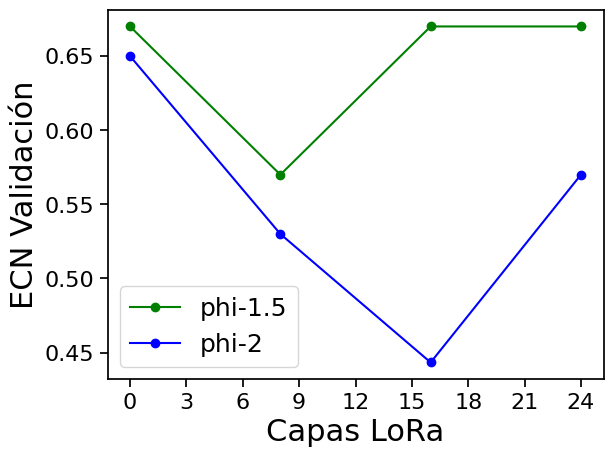

In [35]:
# Convert columns
filtered_df['NEC Validación'] = filtered_df['NEC Validación'].astype(float)
filtered_df['Capas LoRa'] = filtered_df['Capas LoRa'].astype(float).astype(int)

# Filter for socialiqa dataset and group by 'Capas LoRa' and 'Modelo', then calculate the mean of 'NEC Validación'
socialiqa_df = filtered_df[filtered_df['Dataset'] == 'socialiqa']
grouped = socialiqa_df.groupby(['Capas LoRa', 'Modelo'])['NEC Validación'].mean().reset_index()

# Plotting
fig, ax = plt.subplots()
for modelo, color in [('phi-1.5', 'green'), ('phi-2', 'blue')]:
    subset = grouped[grouped['Modelo'] == modelo]
    ax.plot(subset['Capas LoRa'], subset['NEC Validación'], marker='o', linestyle='-', color=color, label=modelo)
sns.set_context("notebook")
ax.set_xlabel('Capas LoRa', fontsize=22)
ax.set_ylabel('ECN Validación', fontsize=22)
ax.tick_params(axis='both', labelsize=16)  # Cambia '10' al tamaño deseado

ax.legend(fontsize=18)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure x-axis values are integers
plt.savefig("/Users/juantollo/Documents/Tesis/resultados/plots/EC Validación_Comparison_for_SocialiQA_Dataset.png", bbox_inches="tight")
plt.show()


/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/3958416341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['TEN Validación'] = filtered_df['TEN Validación'].astype(float)
/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/3958416341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Capas LoRa'] = filtered_df['Capas LoRa'].astype(float).astype(int)


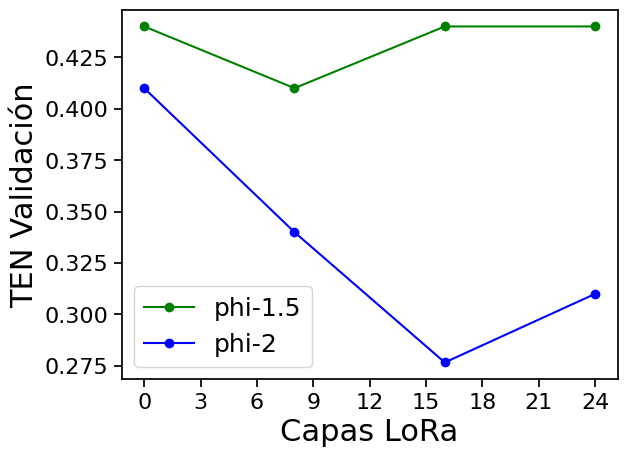

In [36]:
# Convert columns
filtered_df['TEN Validación'] = filtered_df['TEN Validación'].astype(float)
filtered_df['Capas LoRa'] = filtered_df['Capas LoRa'].astype(float).astype(int)

# Filter for socialiqa dataset and group by 'Capas LoRa' and 'Modelo', then calculate the mean of 'NEC Validación'
socialiqa_df = filtered_df[filtered_df['Dataset'] == 'socialiqa']
grouped = socialiqa_df.groupby(['Capas LoRa', 'Modelo'])['TEN Validación'].mean().reset_index()

# Plotting
fig, ax = plt.subplots()
for modelo, color in [('phi-1.5', 'green'), ('phi-2', 'blue')]:
    subset = grouped[grouped['Modelo'] == modelo]
    ax.plot(subset['Capas LoRa'], subset['TEN Validación'], marker='o', linestyle='-', color=color, label=modelo)
sns.set_context("notebook")
ax.set_xlabel('Capas LoRa', fontsize=22)
ax.set_ylabel('TEN Validación', fontsize=22)
ax.tick_params(axis='both', labelsize=16)  # Cambia '10' al tamaño deseado

ax.legend(fontsize=18)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure x-axis values are integers
plt.savefig("/Users/juantollo/Documents/Tesis/resultados/plots/TEN Validación_Comparison_for_SocialiQA_Dataset.png", bbox_inches="tight")
plt.show()


/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/558868595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['NEC Validación'] = filtered_df['NEC Validación'].astype(float)
/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/558868595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Capas LoRa'] = filtered_df['Capas LoRa'].astype(float).astype(int)


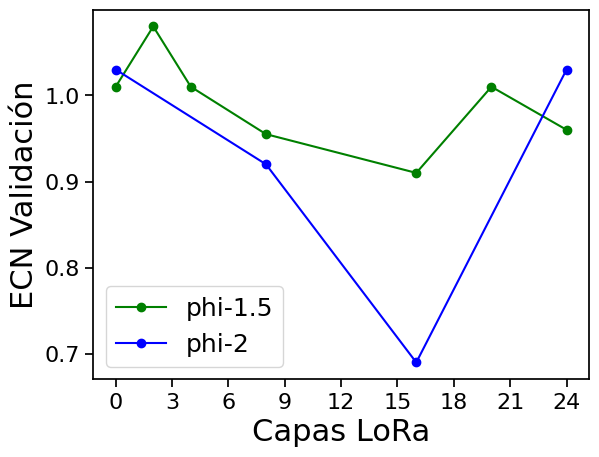

In [37]:
# Convert columns
filtered_df['NEC Validación'] = filtered_df['NEC Validación'].astype(float)
filtered_df['Capas LoRa'] = filtered_df['Capas LoRa'].astype(float).astype(int)

# Filter for socialiqa dataset and group by 'Capas LoRa' and 'Modelo', then calculate the mean of 'NEC Validación'
socialiqa_df = filtered_df[filtered_df['Dataset'] == 'hellaswag']
grouped = socialiqa_df.groupby(['Capas LoRa', 'Modelo'])['NEC Validación'].mean().reset_index()

# Plotting
fig, ax = plt.subplots()
for modelo, color in [('phi-1.5', 'green'), ('phi-2', 'blue')]:
    subset = grouped[grouped['Modelo'] == modelo]
    ax.plot(subset['Capas LoRa'], subset['NEC Validación'], marker='o', linestyle='-', color=color, label=modelo)
sns.set_context("notebook")
ax.set_xlabel('Capas LoRa', fontsize=22)
ax.set_ylabel('ECN Validación', fontsize=22)
ax.tick_params(axis='both', labelsize=16)  # Cambia '10' al tamaño deseado

ax.legend(fontsize=18)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure x-axis values are integers
plt.savefig("/Users/juantollo/Documents/Tesis/resultados/plots/EC Validación_Comparison_for_HellaSwag_Dataset.png", bbox_inches="tight")
plt.show()


/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/3718421410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['TEN Validación'] = filtered_df['TEN Validación'].astype(float)
/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/3718421410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Capas LoRa'] = filtered_df['Capas LoRa'].astype(float).astype(int)


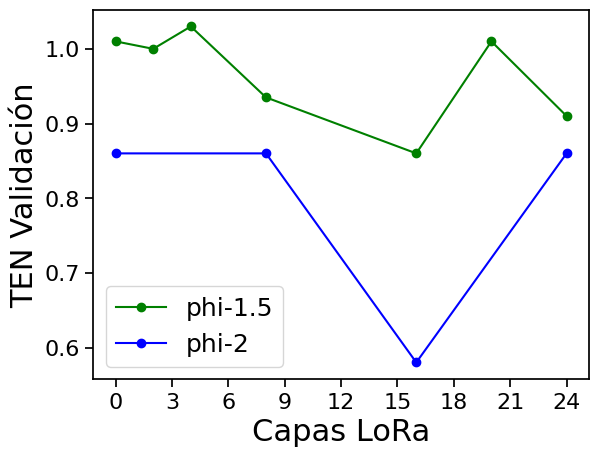

In [38]:
# Convert columns
filtered_df['TEN Validación'] = filtered_df['TEN Validación'].astype(float)
filtered_df['Capas LoRa'] = filtered_df['Capas LoRa'].astype(float).astype(int)

# Filter for socialiqa dataset and group by 'Capas LoRa' and 'Modelo', then calculate the mean of 'NEC Validación'
socialiqa_df = filtered_df[filtered_df['Dataset'] == 'hellaswag']
grouped = socialiqa_df.groupby(['Capas LoRa', 'Modelo'])['TEN Validación'].mean().reset_index()

# Plotting
fig, ax = plt.subplots()
for modelo, color in [('phi-1.5', 'green'), ('phi-2', 'blue')]:
    subset = grouped[grouped['Modelo'] == modelo]
    ax.plot(subset['Capas LoRa'], subset['TEN Validación'], marker='o', linestyle='-', color=color, label=modelo)
sns.set_context("notebook")
ax.set_xlabel('Capas LoRa', fontsize=22)
ax.set_ylabel('TEN Validación', fontsize=22)
ax.tick_params(axis='both', labelsize=16)  # Cambia '10' al tamaño deseado

ax.legend(fontsize=18)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure x-axis values are integers
plt.savefig("/Users/juantollo/Documents/Tesis/resultados/plots/TEN Validación_Comparison_for_HellaSwag_Dataset.png", bbox_inches="tight")
plt.show()


In [39]:
df_res = df.applymap(format_floats)

def filter_ERN_df(model, base_finetuned, dataset, df):
    df_filtered = df.dropna(subset=['Accuracy Validación', "Accuracy Test"])
    df_filtered = df_filtered[
        (df_filtered['Base/Fine-tuning'] == base_finetuned) & 
        (df_filtered['Modelo'] == model) & 
        (df_filtered['Dataset'] == dataset) ]
    df_sorted = df_filtered.sort_values(by='TEN Validación', ascending=True)
    ERN_score = df_sorted.iloc[0]["TEN Test"]
    CE_testeo = df_sorted.iloc[0]["EC Testeo"]
    print(model, base_finetuned, ERN_score, CE_testeo)
    return {"ERN": ERN_score, "CE": CE_testeo}

/var/folders/5l/25t0n5hd2v38hvpz9m0s3x3w0000gn/T/ipykernel_3720/270235540.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_res = df.applymap(format_floats)


In [40]:
# Example data
data = {
    'Modelo': ['phi-1.5 - Base', 'phi-1.5 - Fine-tuned', 'phi-2 - Base', 'phi-2 - Fine-tuned'],
    'SocialIQA ERN': [filter_ERN_df('phi-1.5', 'Base', 'socialiqa', df_res)["ERN"],
                      filter_ERN_df('phi-1.5', 'Fine-tuning', 'socialiqa', df_res)["ERN"],
                      filter_ERN_df('phi-2', 'Base', 'socialiqa', df_res)["ERN"],
                      filter_ERN_df('phi-2', 'Fine-tuning', 'socialiqa', df_res)["ERN"]],
    'SocialIQA CE': [filter_ERN_df('phi-1.5', 'Base', 'socialiqa', df_res)["CE"],
                     filter_ERN_df('phi-1.5', 'Fine-tuning', 'socialiqa', df_res)["CE"],
                     filter_ERN_df('phi-2', 'Base', 'socialiqa', df_res)["CE"],
                     filter_ERN_df('phi-2', 'Fine-tuning', 'socialiqa', df_res)["CE"]],
    'Hellaswag ERN': [filter_ERN_df('phi-1.5', 'Base', 'hellaswag', df_res)["ERN"],
                      filter_ERN_df('phi-1.5', 'Fine-tuning', 'hellaswag', df_res)["ERN"],
                      filter_ERN_df('phi-2', 'Base', 'hellaswag', df_res)["ERN"],
                      filter_ERN_df('phi-2', 'Fine-tuning', 'hellaswag', df_res)["ERN"]],
    'Hellaswag CE': [filter_ERN_df('phi-1.5', 'Base', 'hellaswag', df_res)["CE"],
                     filter_ERN_df('phi-1.5', 'Fine-tuning', 'hellaswag', df_res)["CE"],
                     filter_ERN_df('phi-2', 'Base', 'hellaswag', df_res)["CE"],
                     filter_ERN_df('phi-2', 'Fine-tuning', 'hellaswag', df_res)["CE"]]
}

# Create the DataFrame
df_resultados_finales = pd.DataFrame(data)

# Display the DataFrame
df_resultados_finales.head()

phi-1.5 Base 0.61 0.94
phi-1.5 Fine-tuning 0.58 0.80
phi-2 Base 0.50 0.80
phi-2 Fine-tuning 0.41 0.60
phi-1.5 Base 0.61 0.94
phi-1.5 Fine-tuning 0.58 0.80
phi-2 Base 0.50 0.80
phi-2 Fine-tuning 0.41 0.60
phi-1.5 Base 0.92 1.00
phi-1.5 Fine-tuning 0.80 0.88
phi-2 Base 0.84 1.04
phi-2 Fine-tuning 0.66 0.78
phi-1.5 Base 0.92 1.00
phi-1.5 Fine-tuning 0.80 0.88
phi-2 Base 0.84 1.04
phi-2 Fine-tuning 0.66 0.78


,Modelo,SocialIQA ERN,SocialIQA CE,Hellaswag ERN,Hellaswag CE
0,phi-1.5 - Base,0.61,0.94,0.92,1.00
1,phi-1.5 - Fine-tuned,0.58,0.80,0.80,0.88
2,phi-2 - Base,0.50,0.80,0.84,1.04
3,phi-2 - Fine-tuned,0.41,0.60,0.66,0.78


In [23]:
df[(df["Base/Fine-tuning"] == "Base") & (df["Modelo"] == "phi-1.5")]

,Empresa,Dataset,Modelo,Base/Fine-tuning,Capas LoRa,Tamaño batch,Learning rate,Iters,Adapter,Accuracy Entrenamiento,Accuracy Validación,Accuracy Test,EC Entrenamiento,EC Validación,EC Testeo,ECN Entrenamiento,ECN Validación,ECN Testeo,Error Rate Entrenamiento,Error Rate Validación,Error Rate Test,max_error_train,TEN Entrenamiento,TEN Validación,TEN Test
6,microsoft,socialiqa,phi-1.5,Base,NaN,NaN,0.0e+00,NaN,NaN,0.6962,0.703333,0.591795,0.733293,0.674615,0.938766,0.667710,0.614576,0.854529,0.3038,0.296667,0.408205,0.33,0.453433,0.442786,0.609261
15,microsoft,hellaswag,phi-1.5,Base,NaN,NaN,0.0e+00,NaN,NaN,0.3404,0.320000,0.383000,1.022880,1.013673,0.998639,0.738016,0.734942,0.720659,0.6596,0.680000,0.617000,0.25,0.879467,1.014925,0.920896


In [24]:
df[(df["Base/Fine-tuning"] == "Fine-tuning") & (df["Modelo"] == "phi-1.5")]

,Empresa,Dataset,Modelo,Base/Fine-tuning,Capas LoRa,Tamaño batch,Learning rate,Iters,Adapter,Accuracy Entrenamiento,Accuracy Validación,Accuracy Test,EC Entrenamiento,EC Validación,EC Testeo,ECN Entrenamiento,ECN Validación,ECN Testeo,Error Rate Entrenamiento,Error Rate Validación,Error Rate Test,max_error_train,TEN Entrenamiento,TEN Validación,TEN Test
4,microsoft,socialiqa,phi-1.5,Fine-tuning,8.0,4.0,1.0e-05,5000.0,Best,0.7180,0.726667,0.611282,0.619723,0.573570,0.801048,0.564201,0.522524,0.729169,0.2820,0.273333,0.388718,0.33,0.420896,0.407960,0.580176
2,microsoft,socialiqa,phi-1.5,Fine-tuning,16.0,4.0,1.0e-05,5000.0,Best,0.6962,0.703333,0.591795,0.733293,0.674615,0.938766,0.667710,0.614576,0.854529,0.3038,0.296667,0.408205,0.33,0.453433,0.442786,0.609261
5,microsoft,socialiqa,phi-1.5,Fine-tuning,24.0,4.0,1.0e-05,5000.0,Best,0.6962,0.703333,0.591795,0.733293,0.674615,0.938766,0.667710,0.614576,0.854529,0.3038,0.296667,0.408205,0.33,0.453433,0.442786,0.609261
8,microsoft,hellaswag,phi-1.5,Fine-tuning,16.0,5.0,1.0e-04,2000.0,Best,0.5420,0.510000,0.462000,0.779419,0.843356,0.879117,0.562518,0.611458,0.634407,0.4580,0.490000,0.538000,0.25,0.610667,0.731343,0.802985
10,microsoft,hellaswag,phi-1.5,Fine-tuning,16.0,5.0,1.0e-05,1001.0,Best,0.4422,0.430000,0.399000,0.897563,0.902220,0.928467,0.647599,0.654135,0.670020,0.5578,0.570000,0.601000,0.25,0.743733,0.850746,0.897015
11,microsoft,hellaswag,phi-1.5,Fine-tuning,8.0,5.0,1.0e-04,5000.0,Best,0.3760,0.423333,0.397000,0.948386,0.898908,0.958026,0.684465,0.651734,0.691351,0.6240,0.576667,0.603000,0.25,0.832000,0.860697,0.900000
13,microsoft,hellaswag,phi-1.5,Fine-tuning,24.0,5.0,1.0e-05,1000.0,Best,0.3868,0.393333,0.379000,0.981027,0.960780,0.983740,0.707819,0.696593,0.709907,0.6132,0.606667,0.621000,0.25,0.817600,0.905473,0.926866
16,microsoft,hellaswag,phi-1.5,Fine-tuning,2.0,5.0,1.0e-05,1000.0,Best,0.3410,0.330000,0.367000,1.080011,1.076298,1.053690,0.779237,0.780347,0.760386,0.6590,0.670000,0.633000,0.25,0.878667,1.000000,0.944776
9,microsoft,hellaswag,phi-1.5,Fine-tuning,16.0,5.0,1.0e-05,2000.0,Best,0.3460,0.326667,0.348000,0.964419,0.987329,0.974599,0.696036,0.715842,0.703311,0.6540,0.673333,0.652000,0.25,0.872000,1.004975,0.973134
12,microsoft,hellaswag,phi-1.5,Fine-tuning,8.0,5.0,1.0e-05,1000.0,Best,0.3404,0.320000,0.383000,1.022880,1.013673,0.998639,0.738016,0.734942,0.720659,0.6596,0.680000,0.617000,0.25,0.879467,1.014925,0.920896


In [25]:
import pandas as pd

# Asegúrate de que df_resultados_finales está correctamente definido con los datos necesarios.
# Convertir DataFrame a formato LaTeX incluyendo caption y label
a_caption = "Comparativa de rendimiento entre modelos en su configuración base y después de aplicar fine-tuning para las tareas SocialIQA y Hellaswag. Se evidencia cómo el ajuste fino mejora el desempeño en ambas tareas, destacando el notable incremento en Hellaswag con el modelo Phi 2."
latex_code = df_resultados_finales.to_latex(index=False, 
                                            float_format="{:0.2f}".format, 
                                            escape=False,
                                            caption=a_caption,
                                            label='tab:performance_comparison_TEN_y_ECN',
                                            column_format='lcccc',
                                            position='ht!')

# Guardar la tabla LaTeX en un archivo .tex
with open('tables/error_rate.tex', 'w') as f:
    f.write(latex_code)

print("La tabla LaTeX ha sido generada y guardada correctamente.")

La tabla LaTeX ha sido generada y guardada correctamente.


In [26]:
df_1 = df[df['Modelo'].isin(['phi-2'])]
df_1 = df_1[df_1['Dataset'].isin(['socialiqa'])]
df_1 = df_1[df_1['Base/Fine-tuning'].isin(['Fine-tuning'])]




## Capas Lora

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
print(df_capas.dtypes)
#Filtros dataset original
df_capas = df_capas[df_capas['Modelo'].isin(['phi-1.5', 'phi-2'])]
df_capas = df_capas.loc[df_capas['Iters'] != 1000]

#df_capas = df_capas[df_capas['Iters'].isin(["5000.00"])]


# Adjusting the DataFrame
df_capas['Capas LoRa'] = df_capas['Capas LoRa'].astype('float64')
df_capas['Capas LoRa'] = df_capas['Capas LoRa'].fillna(0)  # Assuming base model has 0 layers
df_capas = df_capas.sort_values(by='Capas LoRa')

# Separate the datasets
socialiqa_df_capas = df_capas[df_capas['Dataset'] == 'socialiqa']
hellaswag_df_capas = df_capas[df_capas['Dataset'] == 'hellaswag']


Empresa                      object
Dataset                      object
Modelo                       object
Base/Fine-tuning             object
Capas LoRa                  float64
Tamaño batch                float64
Learning rate                object
Iters                       float64
Adapter                      object
Accuracy Entrenamiento      float64
Accuracy Validación         float64
Accuracy Test               float64
EC Entrenamiento            float64
EC Validación               float64
EC Testeo                   float64
ECN Entrenamiento           float64
ECN Validación              float64
ECN Testeo                  float64
Error Rate Entrenamiento    float64
Error Rate Validación       float64
Error Rate Test             float64
max_error_train             float64
TEN Entrenamiento           float64
TEN Validación              float64
TEN Test                    float64
dtype: object


In [28]:
socialiqa_df_capas

,Empresa,Dataset,Modelo,Base/Fine-tuning,Capas LoRa,Tamaño batch,Learning rate,Iters,Adapter,Accuracy Entrenamiento,Accuracy Validación,Accuracy Test,EC Entrenamiento,EC Validación,EC Testeo,ECN Entrenamiento,ECN Validación,ECN Testeo,Error Rate Entrenamiento,Error Rate Validación,Error Rate Test,max_error_train,TEN Entrenamiento,TEN Validación,TEN Test
24,microsoft,socialiqa,phi-2,Base,0.0,NaN,0.0e+00,NaN,NaN,0.7362,0.723333,0.667179,0.613033,0.647854,0.795405,0.558206,0.590197,0.724033,0.2638,0.276667,0.332821,0.33,0.393731,0.412935,0.496747
6,microsoft,socialiqa,phi-1.5,Base,0.0,NaN,0.0e+00,NaN,NaN,0.6962,0.703333,0.591795,0.733293,0.674615,0.938766,0.667710,0.614576,0.854529,0.3038,0.296667,0.408205,0.33,0.453433,0.442786,0.609261
21,microsoft,socialiqa,phi-2,Fine-tuning,8.0,5.0,1.0e-05,5000.0,Best,0.7690,0.770000,0.682051,0.497780,0.531790,0.676709,0.453261,0.484462,0.615987,0.2310,0.230000,0.317949,0.33,0.344776,0.343284,0.474550
4,microsoft,socialiqa,phi-1.5,Fine-tuning,8.0,4.0,1.0e-05,5000.0,Best,0.7180,0.726667,0.611282,0.619723,0.573570,0.801048,0.564201,0.522524,0.729169,0.2820,0.273333,0.388718,0.33,0.420896,0.407960,0.580176
20,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-05,5000.0,Best,0.8202,0.820000,0.726667,0.404494,0.439014,0.599919,0.368318,0.399943,0.546088,0.1798,0.180000,0.273333,0.33,0.268358,0.268657,0.407960
2,microsoft,socialiqa,phi-1.5,Fine-tuning,16.0,4.0,1.0e-05,5000.0,Best,0.6962,0.703333,0.591795,0.733293,0.674615,0.938766,0.667710,0.614576,0.854529,0.3038,0.296667,0.408205,0.33,0.453433,0.442786,0.609261
18,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-04,10000.0,Best,0.7362,0.806667,0.721026,0.613033,0.456506,0.610946,0.558206,0.415878,0.556126,0.2638,0.193333,0.278974,0.33,0.393731,0.288557,0.416380
19,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-05,10000.0,Best,0.7362,0.816667,0.722051,0.613033,0.429230,0.606679,0.558206,0.391030,0.552242,0.2638,0.183333,0.277949,0.33,0.393731,0.273632,0.414849
23,microsoft,socialiqa,phi-2,Fine-tuning,24.0,5.0,1.0e-05,5000.0,Best,0.7786,0.790000,0.696410,0.514433,0.568511,0.710064,0.468425,0.517915,0.646349,0.2214,0.210000,0.303590,0.33,0.330448,0.313433,0.453119
5,microsoft,socialiqa,phi-1.5,Fine-tuning,24.0,4.0,1.0e-05,5000.0,Best,0.6962,0.703333,0.591795,0.733293,0.674615,0.938766,0.667710,0.614576,0.854529,0.3038,0.296667,0.408205,0.33,0.453433,0.442786,0.609261


In [29]:
socialiqa_df_capas

,Empresa,Dataset,Modelo,Base/Fine-tuning,Capas LoRa,Tamaño batch,Learning rate,Iters,Adapter,Accuracy Entrenamiento,Accuracy Validación,Accuracy Test,EC Entrenamiento,EC Validación,EC Testeo,ECN Entrenamiento,ECN Validación,ECN Testeo,Error Rate Entrenamiento,Error Rate Validación,Error Rate Test,max_error_train,TEN Entrenamiento,TEN Validación,TEN Test
24,microsoft,socialiqa,phi-2,Base,0.0,NaN,0.0e+00,NaN,NaN,0.7362,0.723333,0.667179,0.613033,0.647854,0.795405,0.558206,0.590197,0.724033,0.2638,0.276667,0.332821,0.33,0.393731,0.412935,0.496747
6,microsoft,socialiqa,phi-1.5,Base,0.0,NaN,0.0e+00,NaN,NaN,0.6962,0.703333,0.591795,0.733293,0.674615,0.938766,0.667710,0.614576,0.854529,0.3038,0.296667,0.408205,0.33,0.453433,0.442786,0.609261
21,microsoft,socialiqa,phi-2,Fine-tuning,8.0,5.0,1.0e-05,5000.0,Best,0.7690,0.770000,0.682051,0.497780,0.531790,0.676709,0.453261,0.484462,0.615987,0.2310,0.230000,0.317949,0.33,0.344776,0.343284,0.474550
4,microsoft,socialiqa,phi-1.5,Fine-tuning,8.0,4.0,1.0e-05,5000.0,Best,0.7180,0.726667,0.611282,0.619723,0.573570,0.801048,0.564201,0.522524,0.729169,0.2820,0.273333,0.388718,0.33,0.420896,0.407960,0.580176
20,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-05,5000.0,Best,0.8202,0.820000,0.726667,0.404494,0.439014,0.599919,0.368318,0.399943,0.546088,0.1798,0.180000,0.273333,0.33,0.268358,0.268657,0.407960
2,microsoft,socialiqa,phi-1.5,Fine-tuning,16.0,4.0,1.0e-05,5000.0,Best,0.6962,0.703333,0.591795,0.733293,0.674615,0.938766,0.667710,0.614576,0.854529,0.3038,0.296667,0.408205,0.33,0.453433,0.442786,0.609261
18,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-04,10000.0,Best,0.7362,0.806667,0.721026,0.613033,0.456506,0.610946,0.558206,0.415878,0.556126,0.2638,0.193333,0.278974,0.33,0.393731,0.288557,0.416380
19,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-05,10000.0,Best,0.7362,0.816667,0.722051,0.613033,0.429230,0.606679,0.558206,0.391030,0.552242,0.2638,0.183333,0.277949,0.33,0.393731,0.273632,0.414849
23,microsoft,socialiqa,phi-2,Fine-tuning,24.0,5.0,1.0e-05,5000.0,Best,0.7786,0.790000,0.696410,0.514433,0.568511,0.710064,0.468425,0.517915,0.646349,0.2214,0.210000,0.303590,0.33,0.330448,0.313433,0.453119
5,microsoft,socialiqa,phi-1.5,Fine-tuning,24.0,4.0,1.0e-05,5000.0,Best,0.6962,0.703333,0.591795,0.733293,0.674615,0.938766,0.667710,0.614576,0.854529,0.3038,0.296667,0.408205,0.33,0.453433,0.442786,0.609261


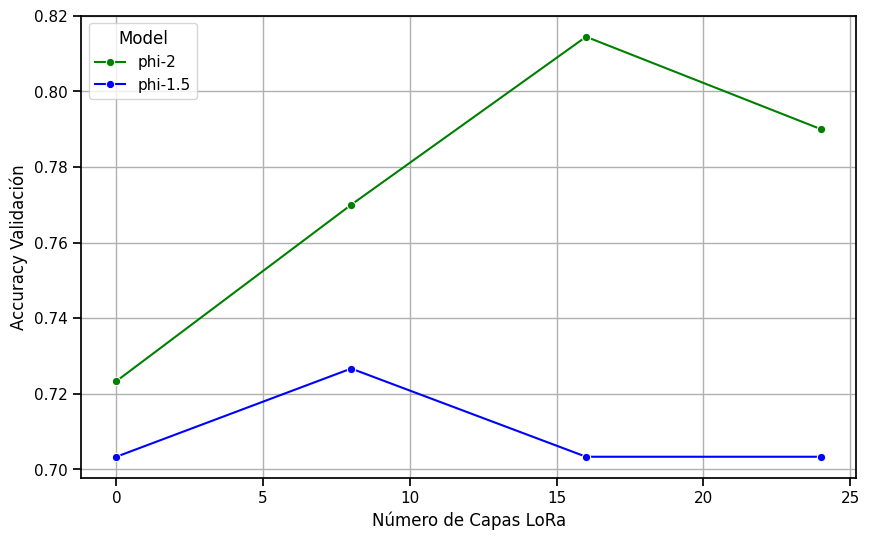

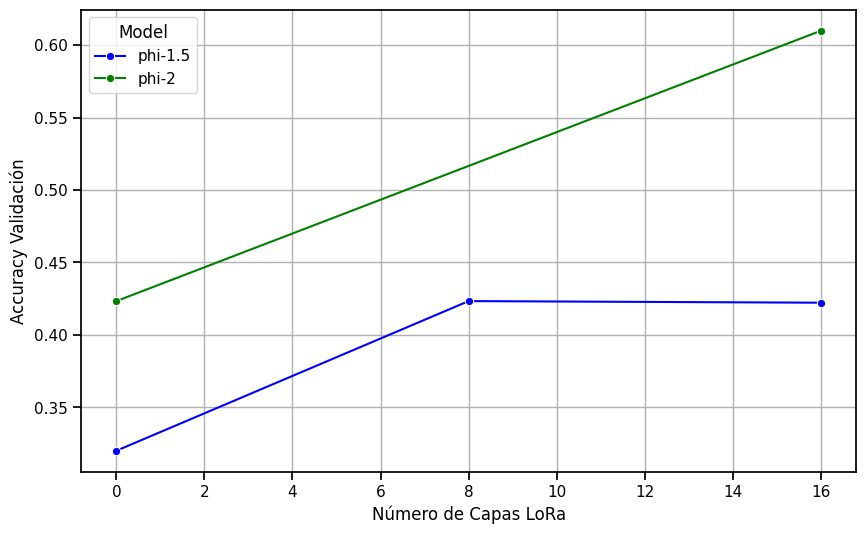

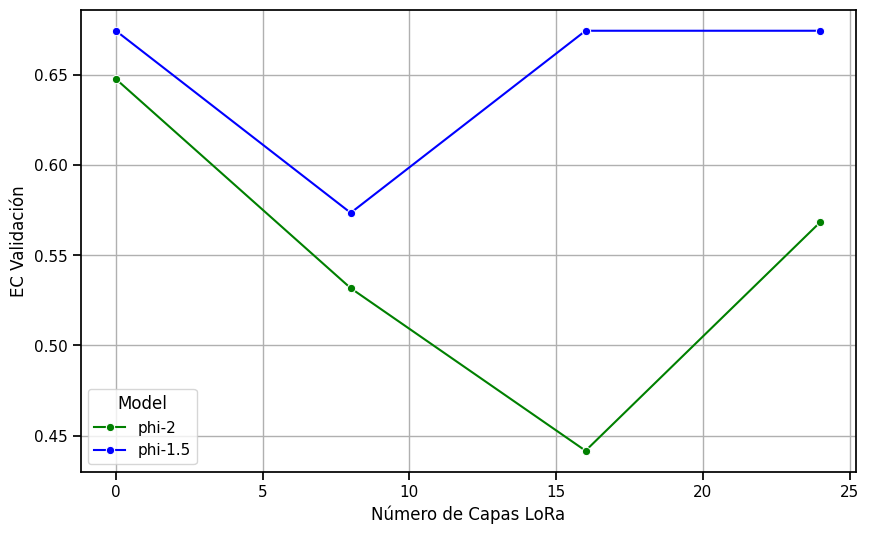

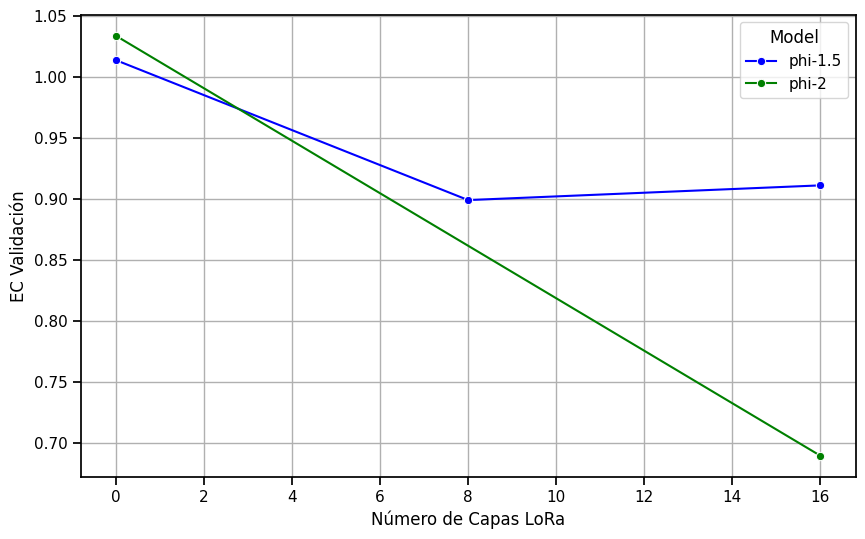

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import unicodedata

# Función para normalizar nombres de archivo y otras cadenas
def normalize_string(s):
    return unicodedata.normalize('NFC', s)

# Plotting function
def plot_accuracy_comparison(df_capas, metrica, dataset_name):
    palette = {
        'phi-1.5': 'blue',
        'phi-2': 'green',
        # Añadir otros modelos si es necesario
    }
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_capas, x='Capas LoRa', y=metrica, hue='Modelo', marker='o', palette=palette, errorbar=None)
    #plt.title(f'Accuracy Comparison for {dataset_name} Dataset')
    plt.xlabel('Número de Capas LoRa')
    plt.ylabel(metrica)
    plt.legend(title='Model')
    plt.grid(True)

    # Ensure y-axis is not inverted
    if plt.gca().yaxis_inverted():
        plt.gca().invert_yaxis()

    # Ensure the 'plots' directory exists
    os.makedirs('plots', exist_ok=True)
    
    # Save the plot
    plt.savefig(f"./plots/{normalize_string(metrica)}_Comparison_for_{normalize_string(dataset_name)}_Dataset.png")    #plt.show()

# Plot for SocialiQA
plot_accuracy_comparison(socialiqa_df_capas, 'Accuracy Validación','SocialiQA')

# Plot for HellaSwag
plot_accuracy_comparison(hellaswag_df_capas, 'Accuracy Validación','HellaSwag')

# Plot for SocialiQA
plot_accuracy_comparison(socialiqa_df_capas, 'EC Validación','SocialiQA')

# Plot for HellaSwag
plot_accuracy_comparison(hellaswag_df_capas, 'EC Validación','HellaSwag')

### Iteraciones

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
print(df_capas.dtypes)
#Filtros dataset original
df_iteraciones = df_iteraciones[df_iteraciones['Modelo'].isin(['phi-1.5', 'phi-2'])]
df_iteraciones = df_iteraciones[df_iteraciones['Base/Fine-tuning'].isin(['Fine-tuning'])]

# # Adjusting the DataFrame
# df_capas['Capas LoRa'] = df_capas['Capas LoRa'].astype('float64')
# df_capas['Capas LoRa'] = df_capas['Capas LoRa'].fillna(0)  # Assuming base model has 0 layers
# df_capas = df_capas.sort_values(by='Capas LoRa')

# Separate the datasets
socialiqa_df_iteraciones = df_iteraciones[df_iteraciones['Dataset'] == 'socialiqa']
hellaswag_df_iteraciones = df_iteraciones[df_iteraciones['Dataset'] == 'hellaswag']


Empresa                      object
Dataset                      object
Modelo                       object
Base/Fine-tuning             object
Capas LoRa                  float64
Tamaño batch                float64
Learning rate                object
Iters                       float64
Adapter                      object
Accuracy Entrenamiento      float64
Accuracy Validación         float64
Accuracy Test               float64
EC Entrenamiento            float64
EC Validación               float64
EC Testeo                   float64
ECN Entrenamiento           float64
ECN Validación              float64
ECN Testeo                  float64
Error Rate Entrenamiento    float64
Error Rate Validación       float64
Error Rate Test             float64
max_error_train             float64
TEN Entrenamiento           float64
TEN Validación              float64
TEN Test                    float64
dtype: object


In [32]:
hellaswag_df_iteraciones

,Empresa,Dataset,Modelo,Base/Fine-tuning,Capas LoRa,Tamaño batch,Learning rate,Iters,Adapter,Accuracy Entrenamiento,Accuracy Validación,Accuracy Test,EC Entrenamiento,EC Validación,EC Testeo,ECN Entrenamiento,ECN Validación,ECN Testeo,Error Rate Entrenamiento,Error Rate Validación,Error Rate Test,max_error_train,TEN Entrenamiento,TEN Validación,TEN Test
27,microsoft,hellaswag,phi-2,Fine-tuning,16.0,4.0,1.0e-05,5000.0,Best,0.406869,0.610000,0.561,1.054808,0.689272,0.775235,0.761061,0.499742,0.559441,0.593131,0.390000,0.439,0.25,0.790842,0.582090,0.655224
8,microsoft,hellaswag,phi-1.5,Fine-tuning,16.0,5.0,1.0e-04,2000.0,Best,0.542000,0.510000,0.462,0.779419,0.843356,0.879117,0.562518,0.611458,0.634407,0.458000,0.490000,0.538,0.25,0.610667,0.731343,0.802985
10,microsoft,hellaswag,phi-1.5,Fine-tuning,16.0,5.0,1.0e-05,1001.0,Best,0.442200,0.430000,0.399,0.897563,0.902220,0.928467,0.647599,0.654135,0.670020,0.557800,0.570000,0.601,0.25,0.743733,0.850746,0.897015
29,microsoft,hellaswag,phi-2,Fine-tuning,8.0,5.0,1.0e-05,1000.0,Best,0.406400,0.426667,0.442,1.055544,0.922032,0.915048,0.761584,0.668500,0.660336,0.593600,0.573333,0.558,0.25,0.791467,0.855721,0.832836
11,microsoft,hellaswag,phi-1.5,Fine-tuning,8.0,5.0,1.0e-04,5000.0,Best,0.376000,0.423333,0.397,0.948386,0.898908,0.958026,0.684465,0.651734,0.691351,0.624000,0.576667,0.603,0.25,0.832000,0.860697,0.900000
30,microsoft,hellaswag,phi-2,Fine-tuning,24.0,5.0,1.0e-05,1000.0,Best,0.406400,0.423333,0.475,1.055544,1.033648,0.930430,0.761584,0.749425,0.671437,0.593600,0.576667,0.525,0.25,0.791467,0.860697,0.783582
13,microsoft,hellaswag,phi-1.5,Fine-tuning,24.0,5.0,1.0e-05,1000.0,Best,0.386800,0.393333,0.379,0.981027,0.960780,0.983740,0.707819,0.696593,0.709907,0.613200,0.606667,0.621,0.25,0.817600,0.905473,0.926866
16,microsoft,hellaswag,phi-1.5,Fine-tuning,2.0,5.0,1.0e-05,1000.0,Best,0.341000,0.330000,0.367,1.080011,1.076298,1.053690,0.779237,0.780347,0.760386,0.659000,0.670000,0.633,0.25,0.878667,1.000000,0.944776
9,microsoft,hellaswag,phi-1.5,Fine-tuning,16.0,5.0,1.0e-05,2000.0,Best,0.346000,0.326667,0.348,0.964419,0.987329,0.974599,0.696036,0.715842,0.703311,0.654000,0.673333,0.652,0.25,0.872000,1.004975,0.973134
12,microsoft,hellaswag,phi-1.5,Fine-tuning,8.0,5.0,1.0e-05,1000.0,Best,0.340400,0.320000,0.383,1.022880,1.013673,0.998639,0.738016,0.734942,0.720659,0.659600,0.680000,0.617,0.25,0.879467,1.014925,0.920896


In [33]:
socialiqa_df_iteraciones

,Empresa,Dataset,Modelo,Base/Fine-tuning,Capas LoRa,Tamaño batch,Learning rate,Iters,Adapter,Accuracy Entrenamiento,Accuracy Validación,Accuracy Test,EC Entrenamiento,EC Validación,EC Testeo,ECN Entrenamiento,ECN Validación,ECN Testeo,Error Rate Entrenamiento,Error Rate Validación,Error Rate Test,max_error_train,TEN Entrenamiento,TEN Validación,TEN Test
20,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-05,5000.0,Best,0.8202,0.820000,0.726667,0.404494,0.439014,0.599919,0.368318,0.399943,0.546088,0.1798,0.180000,0.273333,0.33,0.268358,0.268657,0.407960
19,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-05,10000.0,Best,0.7362,0.816667,0.722051,0.613033,0.429230,0.606679,0.558206,0.391030,0.552242,0.2638,0.183333,0.277949,0.33,0.393731,0.273632,0.414849
18,microsoft,socialiqa,phi-2,Fine-tuning,16.0,5.0,1.0e-04,10000.0,Best,0.7362,0.806667,0.721026,0.613033,0.456506,0.610946,0.558206,0.415878,0.556126,0.2638,0.193333,0.278974,0.33,0.393731,0.288557,0.416380
23,microsoft,socialiqa,phi-2,Fine-tuning,24.0,5.0,1.0e-05,5000.0,Best,0.7786,0.790000,0.696410,0.514433,0.568511,0.710064,0.468425,0.517915,0.646349,0.2214,0.210000,0.303590,0.33,0.330448,0.313433,0.453119
21,microsoft,socialiqa,phi-2,Fine-tuning,8.0,5.0,1.0e-05,5000.0,Best,0.7690,0.770000,0.682051,0.497780,0.531790,0.676709,0.453261,0.484462,0.615987,0.2310,0.230000,0.317949,0.33,0.344776,0.343284,0.474550
4,microsoft,socialiqa,phi-1.5,Fine-tuning,8.0,4.0,1.0e-05,5000.0,Best,0.7180,0.726667,0.611282,0.619723,0.573570,0.801048,0.564201,0.522524,0.729169,0.2820,0.273333,0.388718,0.33,0.420896,0.407960,0.580176
25,microsoft,socialiqa,phi-2,Fine-tuning,2.0,5.0,1.0e-05,1000.0,Best,0.7384,0.726667,0.655897,0.618904,0.646047,0.799108,0.563552,0.588550,0.727403,0.2616,0.273333,0.344103,0.33,0.390448,0.407960,0.513586
17,microsoft,socialiqa,phi-2,Fine-tuning,20.0,5.0,1.0e-05,1000.0,Best,0.7504,0.723333,0.669231,0.561333,0.604268,0.745034,0.511130,0.550489,0.678182,0.2496,0.276667,0.330769,0.33,0.372537,0.412935,0.493685
22,microsoft,socialiqa,phi-2,Fine-tuning,8.0,5.0,1.0e-05,1000.0,Best,0.7346,0.710000,0.656923,0.573680,0.603110,0.736992,0.522373,0.549434,0.670861,0.2654,0.290000,0.343077,0.33,0.396119,0.432836,0.512055
2,microsoft,socialiqa,phi-1.5,Fine-tuning,16.0,4.0,1.0e-05,5000.0,Best,0.6962,0.703333,0.591795,0.733293,0.674615,0.938766,0.667710,0.614576,0.854529,0.3038,0.296667,0.408205,0.33,0.453433,0.442786,0.609261


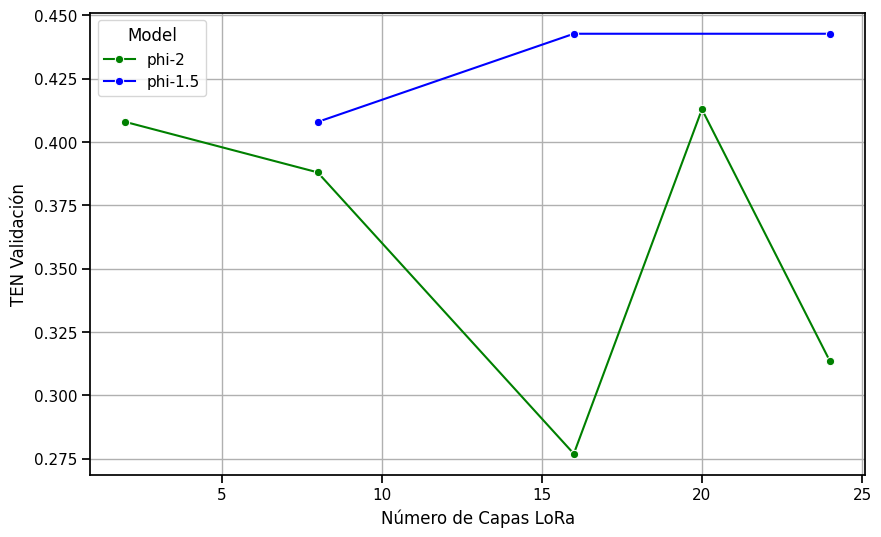

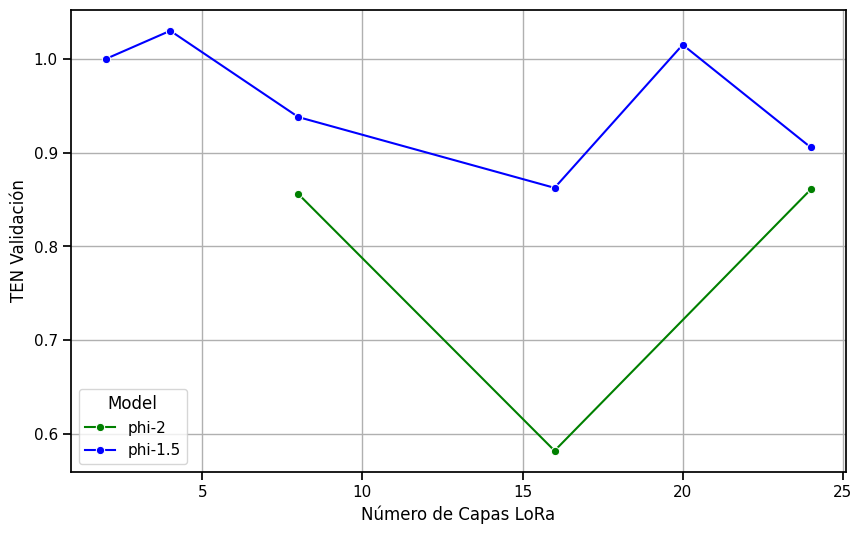

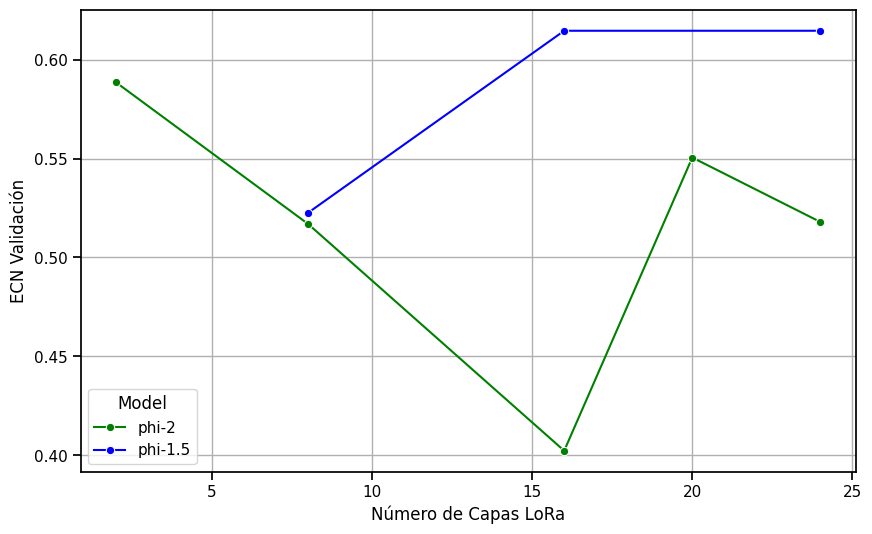

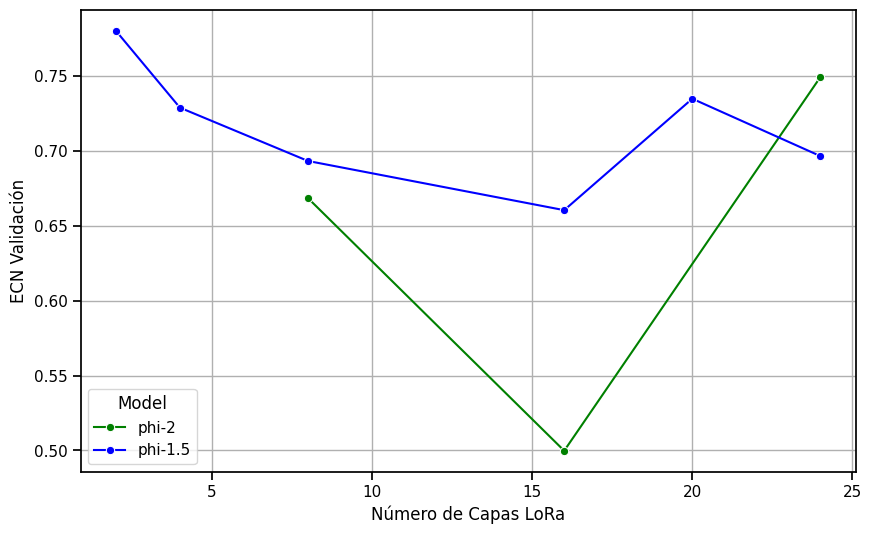

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import unicodedata

# Función para normalizar nombres de archivo y otras cadenas
def normalize_string(s):
    return unicodedata.normalize('NFC', s)

# Plotting function
def plot_accuracy_comparison(df_capas, metrica, dataset_name):
    palette = {
        'phi-1.5': 'blue',
        'phi-2': 'green',
        # Añadir otros modelos si es necesario
    }
    #df_capas = df_capas[df_capas['Iters'] = 1000]

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_capas, x='Capas LoRa', y=metrica, hue='Modelo', marker='o', palette=palette, errorbar=None)
    #plt.title(f'Accuracy Comparison for {dataset_name} Dataset')
    plt.xlabel('Número de Capas LoRa')
    plt.ylabel(metrica)
    plt.legend(title='Model')
    plt.grid(True)

    # Ensure y-axis is not inverted
    if plt.gca().yaxis_inverted():
        plt.gca().invert_yaxis()

    # Ensure the 'plots' directory exists
    os.makedirs('plots', exist_ok=True)
    
    # Save the plot
    plt.savefig(f"./plots/{normalize_string(metrica)}_Comparison_for_{normalize_string(dataset_name)}_Dataset.png")    #plt.show()

# Plot for SocialiQA
plot_accuracy_comparison(socialiqa_df_iteraciones, 'TEN Validación','SocialiQA')

# Plot for HellaSwag
plot_accuracy_comparison(hellaswag_df_iteraciones, 'TEN Validación','HellaSwag')

# Plot for SocialiQA
plot_accuracy_comparison(socialiqa_df_iteraciones, 'ECN Validación','SocialiQA')

# Plot for HellaSwag
plot_accuracy_comparison(hellaswag_df_iteraciones, 'ECN Validación','HellaSwag')

## Curvas de pérdida

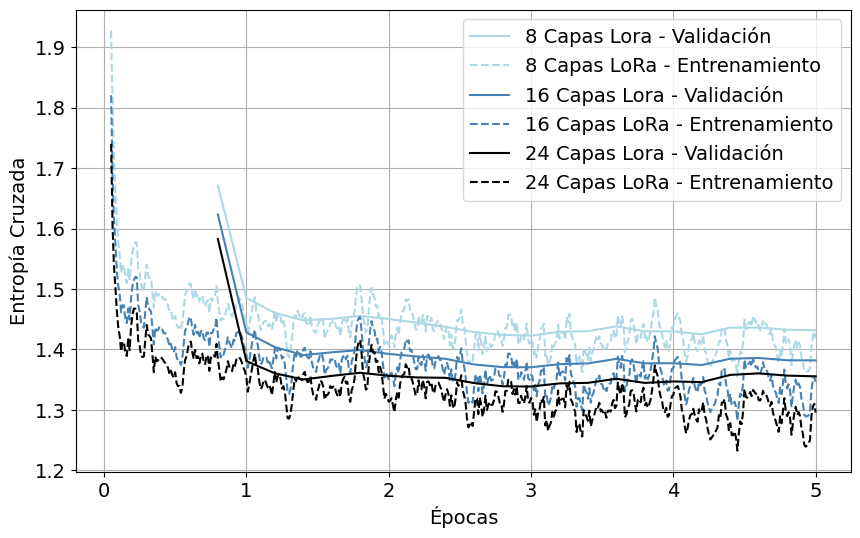

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Rutas a los archivos CSV para validación y entrenamiento
val_file_paths = [
    "/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/socialiqa/8/5/5000/1e-5/Val_loss.csv",
    "/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/socialiqa/16/5/5000/1e-5/Val_loss.csv",
    "/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/socialiqa/24/5/5000/1e-5/Val_loss.csv"
]

train_file_paths = [
    "/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/socialiqa/8/5/5000/1e-5/Train_loss.csv",
    "/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/socialiqa/16/5/5000/1e-5/Train_loss.csv",
    "/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/socialiqa/24/5/5000/1e-5/Train_loss.csv"
]

# Asumimos que las columnas de pérdida se llaman 'Loss' y que hay una columna 'Iteration' que representa las iteraciones.
# También asumimos que conoces el número de batches por epoch.
batches_per_epoch = 5  # Ajusta este valor según tu configuración
loss_column = 'Loss'
iteration_column = 'Iteration'

# Cargar los datos en DataFrames para validación y entrenamiento
val_dfs = [pd.read_csv(file_path) for file_path in val_file_paths]
train_dfs = [pd.read_csv(file_path) for file_path in train_file_paths]

# Agregar una columna para identificar el número de capas
for i, (val_df, train_df) in enumerate(zip(val_dfs, train_dfs)):
    val_df['Lora_Layers'] = [8, 16, 24][i]
    train_df['Lora_Layers'] = [8, 16, 24][i]
    val_df['Epoch'] = (val_df[iteration_column] * batches_per_epoch) / 5000  # Convertir iteraciones a épocas
    train_df['Epoch'] = (train_df[iteration_column] * batches_per_epoch) / 5000  # Convertir iteraciones a épocas
    val_df[loss_column] = val_df[loss_column].rolling(window=5).mean()  # Aplicar media móvil a la pérdida de validación
    train_df[loss_column] = train_df[loss_column].rolling(window=5).mean()  # Aplicar media móvil a la pérdida de entrenamiento

# Concatenar todos los DataFrames en uno solo
combined_val_df = pd.concat(val_dfs, ignore_index=True)
combined_train_df = pd.concat(train_dfs, ignore_index=True)

# Definir colores pasteles nítidos
colors = {
    8: '#add8e6',  # Light Blue
    16: '#4682b4', # Steel Blue
    24: 'black'  # Dark Blue
}

# Graficar los datos
plt.figure(figsize=(10, 6))
for lora_layers in combined_val_df['Lora_Layers'].unique():
    val_subset = combined_val_df[combined_val_df['Lora_Layers'] == lora_layers]
    train_subset = combined_train_df[combined_train_df['Lora_Layers'] == lora_layers]
    color = colors[lora_layers]
    plt.plot(val_subset['Epoch'], val_subset[loss_column], label=f'{lora_layers} Capas Lora - Validación', color=color)
    #plt.plot(val_subset['Epoch'], val_subset[loss_column], label=f'{lora_layers} Lora Layers - Validation', color=color, marker='o')
    plt.plot(train_subset['Epoch'], train_subset[loss_column], linestyle='--', label=f'{lora_layers} Capas LoRa - Entrenamiento', color=color)

plt.rcParams.update({'font.size': 14})  # Aumenta este valor para fuentes más grandes

plt.xlabel('Épocas')
plt.ylabel('Entropía Cruzada')
#plt.yscale('log')  # Aplicar escala logarítmica al eje y si es necesario
#plt.title('Evolution of Training and Validation Loss for Different Lora Layers')
plt.legend()
plt.grid(True)
plt.savefig('plots/evolution_perplijidad.png')
plt.show()

## Distribución $\frac{targets}{Vocabulario}$

Nos interesa ver cómo se distribuyen los scores de los tokens targets antes o después de fine tunear. Es esperable que los targetes tenga una proporción menor antes de fine tunear.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import PreTrainedTokenizerFast

/Users/juantollo/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import PreTrainedTokenizerFast

def scores_distribution(base_logits, base_targets, fine_tuned_logits, fine_tuned_targets, daatast, modelo):
    tokenizer_path = "./tokenizer/tokenizer.json"
    tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)

    # Decodificar los targets usando el tokenizer
    decoded_base_targets = tokenizer.batch_decode(base_targets, skip_special_tokens=True)
    decoded_fine_tuned_targets = tokenizer.batch_decode(fine_tuned_targets, skip_special_tokens=True)
    
    # Obtener únicos
    unique_base_targets = np.unique(decoded_base_targets)
    print(decoded_base_targets)
    unique_fine_tuned_targets = np.unique(decoded_fine_tuned_targets)

    # Función softmax
    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)

    # Aplicar softmax a los logits
    base_scores = softmax(base_logits)
    fine_tuned_scores = softmax(fine_tuned_logits)

    # Calcular la suma total de scores
    base_total_scores = base_scores.sum(axis=1).sum()
    fine_tuned_total_scores = fine_tuned_scores.sum(axis=1).sum()

    # Calcular scores para cada target individualmente y promediar sobre todas las instancias
    base_target_scores = np.array([base_scores[:, np.where(base_targets == target)[0]].sum() for target in np.unique(base_targets)])
    fine_tuned_target_scores = np.array([fine_tuned_scores[:, np.where(fine_tuned_targets == target)[0]].sum() for target in np.unique(fine_tuned_targets)])

    # Calcular la suma de scores de los targets y los "Otros"
    base_sum_target_scores = base_target_scores.sum()
    fine_tuned_sum_target_scores = fine_tuned_target_scores.sum()

    base_sum_other_scores = base_total_scores - base_sum_target_scores
    fine_tuned_sum_other_scores = fine_tuned_total_scores - fine_tuned_sum_target_scores

    # Porcentajes para targets y "Otros"
    base_percentages = 100 * base_target_scores / base_total_scores
    fine_tuned_percentages = 100 * fine_tuned_target_scores / fine_tuned_total_scores

    other_base_percentage = 100 * base_sum_other_scores / base_total_scores
    other_fine_tuned_percentage = 100 * fine_tuned_sum_other_scores / fine_tuned_total_scores

    print("Base Targets Decoded:", decoded_base_targets)
    print("Fine Tuned Targets Decoded:", decoded_fine_tuned_targets)
    
    print("Unique Base Targets:", unique_base_targets)
    print("Unique Fine Tuned Targets:", unique_fine_tuned_targets)

    # Revisar si la etiqueta "B" está correctamente identificada en los arrays de targets
    #print("Is 'B' in Base Targets?", "B" in decoded_base_targets)
    #print("Is 'B' in Fine Tuned Targets?", "B" in decoded_fine_tuned_targets)
    
    # Ejemplo de cómo deberías calcular cada score para un target, asegurándote de que los índices son correctos
    base_target_scores = []
    for target in np.unique(base_targets):
        target_indices = np.where(base_targets == target)[0]
        target_score_sum = base_scores[:, target_indices].sum()
        base_target_scores.append(target_score_sum)
        print(f"Target: {target}, Score: {target_score_sum}")
    ### Visualizar los Resultados con Porcentajes
    colors = ['#92a8d1', '#f4acb7', '#9df6ff', '#a0c4ff', '#bdb2ff', '#ffc6ff']  # Colores pasteles

    fig, ax = plt.subplots(figsize=(12, 8))
    width = 0.35  # ancho de las barras

    # Barras para el modelo base
    base_bars = ax.bar(np.arange(len(unique_base_targets)), base_percentages, width, label=f'{modelo} Base', color='lightblue')

    # Barras para el modelo con ajuste fino
    fine_tuned_bars = ax.bar(np.arange(len(unique_fine_tuned_targets)) + width, fine_tuned_percentages, width, label=f'{modelo} Fine-Tuned', color='lightgreen')

    ax.bar(len(unique_base_targets), other_base_percentage, width, color='lightblue')
    ax.bar(len(unique_fine_tuned_targets) + width, other_fine_tuned_percentage, width, color='lightgreen')

    # Añadir etiquetas y porcentajes sobre cada barra
    ax.set_ylabel('Score Percentage')
    ax.set_xticks(np.arange(len(unique_base_targets) + 1))
    ax.set_xticklabels(list(unique_base_targets) + ['Otras'], rotation=45)
    ax.legend()

    plt.savefig(f"./plots/Comparison_{modelo}_Base_Fine_Tuned_Score_Distributions_for_{daatast}.png")
    plt.show()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import PreTrainedTokenizerFast

def scores_distribution(base_logits, base_targets, fine_tuned_logits, fine_tuned_targets, daatast, modelo):
    tokenizer_path = "./tokenizer/tokenizer.json"
    tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)

    # Decodificar los targets usando el tokenizer
    decoded_base_targets = tokenizer.batch_decode(base_targets, skip_special_tokens=True)
    decoded_fine_tuned_targets = tokenizer.batch_decode(fine_tuned_targets, skip_special_tokens=True)
    
    # Obtener únicos
    unique_base_targets = np.unique(decoded_base_targets)

   # Etiquetas de interés
    labels_of_interest = unique_base_targets

    # Inicializar el diccionario con las etiquetas de interés
    prop_labels = {label: 0 for label in labels_of_interest}

    # Calcular el conteo de cada etiqueta
    total_count = len(decoded_base_targets)
    label_counts = {label: decoded_base_targets.count(label) for label in unique_base_targets}

    # Asignar proporciones a las etiquetas de interés y calcular 'Otras'
    for label in labels_of_interest:
        if label in label_counts:
            prop_labels[label] = label_counts[label] / total_count * 100
    print(prop_labels)        
            
    unique_fine_tuned_targets = np.unique(decoded_fine_tuned_targets)

    # Función softmax
    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)

    # Aplicar softmax a los logits
    base_scores = softmax(base_logits)
    fine_tuned_scores = softmax(fine_tuned_logits)

    # Calcular la suma total de scores
    base_total_scores = base_scores.sum(axis=1).sum()
    fine_tuned_total_scores = fine_tuned_scores.sum(axis=1).sum()

    # Calcular scores para cada target individualmente y promediar sobre todas las instancias
    base_target_scores = np.array([base_scores[:, np.where(base_targets == target)[0]].sum() for target in np.unique(base_targets)])
    fine_tuned_target_scores = np.array([fine_tuned_scores[:, np.where(fine_tuned_targets == target)[0]].sum() for target in np.unique(fine_tuned_targets)])

    # Calcular la suma de scores de los targets y los "Otros"
    base_sum_target_scores = base_target_scores.sum()
    fine_tuned_sum_target_scores = fine_tuned_target_scores.sum()

    base_sum_other_scores = base_total_scores - base_sum_target_scores
    fine_tuned_sum_other_scores = fine_tuned_total_scores - fine_tuned_sum_target_scores

    # Porcentajes para targets y "Otros"
    base_percentages = 100 * base_target_scores / base_total_scores
    fine_tuned_percentages = 100 * fine_tuned_target_scores / fine_tuned_total_scores

    other_base_percentage = 100 * base_sum_other_scores / base_total_scores
    other_fine_tuned_percentage = 100 * fine_tuned_sum_other_scores / fine_tuned_total_scores

    print("Base Targets Decoded:", decoded_base_targets)
    print("Fine Tuned Targets Decoded:", decoded_fine_tuned_targets)
    
    print("Unique Base Targets:", unique_base_targets)
    print("Unique Fine Tuned Targets:", unique_fine_tuned_targets)

    # Revisar si la etiqueta "B" está correctamente identificada en los arrays de targets
    #print("Is 'B' in Base Targets?", "B" in decoded_base_targets)
    #print("Is 'B' in Fine Tuned Targets?", "B" in decoded_fine_tuned_targets)
    
    # Ejemplo de cómo deberías calcular cada score para un target, asegurándote de que los índices son correctos
    base_target_scores = []
    for target in np.unique(base_targets):
        target_indices = np.where(base_targets == target)[0]
        target_score_sum = base_scores[:, target_indices].sum()
        base_target_scores.append(target_score_sum)
        print(f"Target: {target}, Score: {target_score_sum}")
    ### Visualizar los Resultados con Porcentajes
    colors = ['#92a8d1', '#f4acb7', '#9df6ff', '#a0c4ff', '#bdb2ff', '#ffc6ff']  # Colores pasteles

    fig, ax = plt.subplots(figsize=(12, 8))
    width = 0.25  # ancho de las barras

    # Barras para el modelo base
    #base_bars = ax.bar(np.arange(len(unique_base_targets)), base_percentages, width, label=f'{modelo} Base', color='lightblue')

    # Barras para el modelo con ajuste fino
    #fine_tuned_bars = ax.bar(np.arange(len(unique_fine_tuned_targets)) + width, fine_tuned_percentages, width, label=f'{modelo} Fine-Tuned', color='lightgreen')

    ax.bar(len(unique_base_targets), other_base_percentage, width, color='lightblue')
    ax.bar(len(unique_fine_tuned_targets) + width, other_fine_tuned_percentage, width, color='lightgreen')

    # Convertir prop_labels a una lista para el orden correcto en el gráfico
    prop_label_values = [prop_labels.get(label, 0) for label in unique_base_targets] + [prop_labels.get('Other', 0)]
    print("prompt values", prop_label_values)
    # Añadir barra para prop_labels
    
    # Ajustar la posición de las barras rojas para que coincidan con las otras
    #prop_labels_bars = ax.bar(np.arange(len(prop_label_values)) + 1.5*width, prop_label_values, width, label=f'Labels', color='lightcoral')
    
    # Barras para el modelo base
    base_bars = ax.bar(np.arange(len(unique_base_targets)) - width, base_percentages, width, label=f'{modelo} Base', color='lightblue')

    # Barras para el modelo con ajuste fino
    fine_tuned_bars = ax.bar(np.arange(len(unique_fine_tuned_targets)), fine_tuned_percentages, width, label=f'{modelo} Fine-Tuned', color='lightgreen')

    # Barras para prop_labels
    prop_labels_bars = ax.bar(np.arange(len(prop_label_values)) + width, prop_label_values, width, label=f'Labels', color='lightcoral')
    
    # Añadir etiquetas y porcentajes sobre cada barra
    ax.set_ylabel('Score %', fontsize=28)
    #ax.set_xlabel('Respuesta', fontsize=28)
    ax.set_xticks(np.arange(len(unique_base_targets) + 1))
    ax.set_xticklabels(list(unique_base_targets) + ['Otras'], rotation=45, fontsize=24)
    ax.legend()
    # Añadir etiquetas y porcentajes sobre cada barra
    ax.set_xticklabels(list(unique_base_targets) + ['Otras'], rotation=45, fontsize=24)
    ax.legend(fontsize=22, framealpha=0.5)  # Ajusta el valor de 'framealpha' según desees, por ejemplo, 0.5 para semi-transparencia    ax.legend(fontsize=18)  # Ajustar tamaño de la fuente para la leyenda aquí
    ax.tick_params(axis='both', labelsize=24)  # Ajustar tamaño de ticks para x e y


    plt.savefig(f"./plots/Comparison_{modelo}_Base_Fine_Tuned_Score_Distributions_for_{daatast}.png")
    plt.show()

## Phi 2 Hellaswag 

{' A': 24.0, ' B': 26.3, ' C': 24.6, ' D': 25.1}
Base Targets Decoded: [' B', ' A', ' A', ' C', ' B', ' C', ' D', ' B', ' D', ' D', ' C', ' A', ' B', ' B', ' B', ' C', ' A', ' A', ' A', ' A', ' A', ' C', ' B', ' A', ' A', ' D', ' C', ' B', ' C', ' C', ' D', ' C', ' A', ' D', ' A', ' D', ' C', ' C', ' A', ' D', ' A', ' A', ' D', ' B', ' C', ' C', ' D', ' C', ' B', ' C', ' C', ' C', ' D', ' A', ' B', ' C', ' D', ' C', ' A', ' A', ' B', ' C', ' C', ' B', ' D', ' A', ' B', ' C', ' A', ' D', ' D', ' D', ' C', ' C', ' A', ' B', ' A', ' D', ' D', ' C', ' A', ' D', ' D', ' D', ' C', ' D', ' A', ' D', ' A', ' C', ' A', ' A', ' D', ' A', ' C', ' D', ' B', ' A', ' B', ' B', ' C', ' C', ' B', ' A', ' B', ' C', ' C', ' D', ' C', ' B', ' C', ' D', ' D', ' B', ' B', ' A', ' D', ' D', ' A', ' B', ' D', ' B', ' B', ' A', ' A', ' A', ' B', ' B', ' C', ' A', ' A', ' A', ' B', ' A', ' D', ' B', ' B', ' B', ' D', ' A', ' A', ' B', ' B', ' B', ' A', ' C', ' B', ' A', ' B', ' C', ' C', ' A', ' D', ' B', ' B'

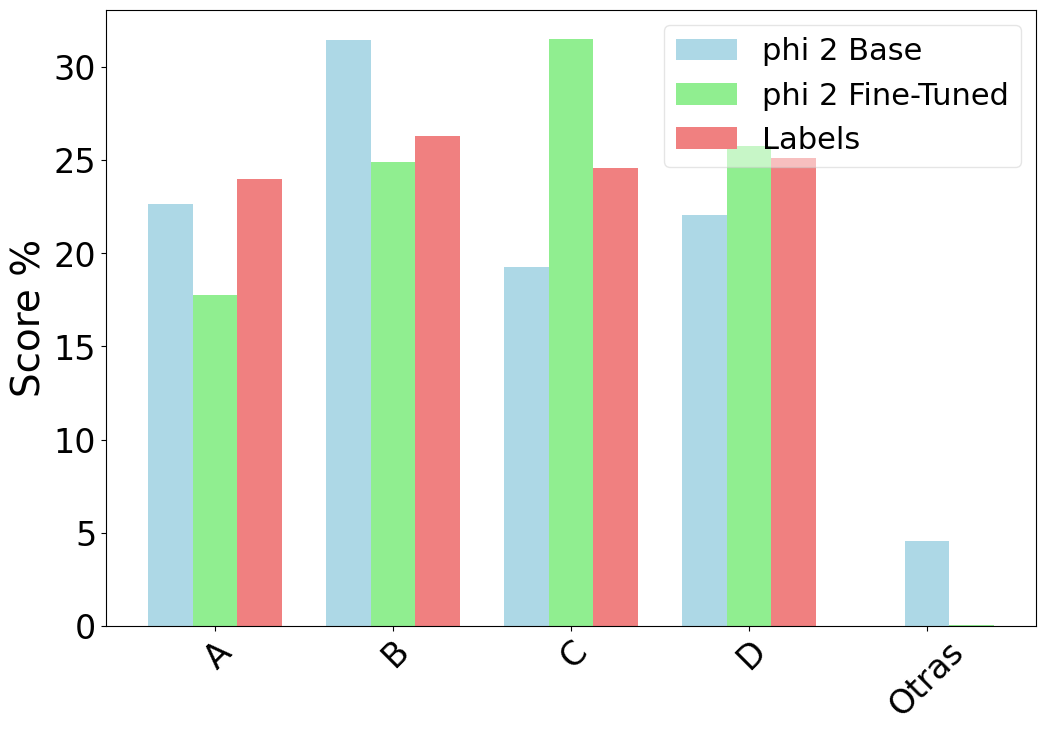

In [27]:

# Cargar las etiquetas de targets y logits del modelo base y ajustado
base_logits = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/hellaswag/Base/test_all_logits.npy')
base_targets = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/hellaswag/Base//test_all_targets.npy')

fine_tuned_logits = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/hellaswag/16/4/5000/1e-5/test_all_logits.npy')
fine_tuned_targets = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/hellaswag/16/4/5000/1e-5/test_all_targets.npy')

scores_distribution(base_logits, base_targets, fine_tuned_logits, fine_tuned_targets, "hellaswag","phi 2")

## Phi 1.5 HellaSwag

{' A': 24.0, ' B': 26.3, ' C': 24.6, ' D': 25.1}
Base Targets Decoded: [' B', ' A', ' A', ' C', ' B', ' C', ' D', ' B', ' D', ' D', ' C', ' A', ' B', ' B', ' B', ' C', ' A', ' A', ' A', ' A', ' A', ' C', ' B', ' A', ' A', ' D', ' C', ' B', ' C', ' C', ' D', ' C', ' A', ' D', ' A', ' D', ' C', ' C', ' A', ' D', ' A', ' A', ' D', ' B', ' C', ' C', ' D', ' C', ' B', ' C', ' C', ' C', ' D', ' A', ' B', ' C', ' D', ' C', ' A', ' A', ' B', ' C', ' C', ' B', ' D', ' A', ' B', ' C', ' A', ' D', ' D', ' D', ' C', ' C', ' A', ' B', ' A', ' D', ' D', ' C', ' A', ' D', ' D', ' D', ' C', ' D', ' A', ' D', ' A', ' C', ' A', ' A', ' D', ' A', ' C', ' D', ' B', ' A', ' B', ' B', ' C', ' C', ' B', ' A', ' B', ' C', ' C', ' D', ' C', ' B', ' C', ' D', ' D', ' B', ' B', ' A', ' D', ' D', ' A', ' B', ' D', ' B', ' B', ' A', ' A', ' A', ' B', ' B', ' C', ' A', ' A', ' A', ' B', ' A', ' D', ' B', ' B', ' B', ' D', ' A', ' A', ' B', ' B', ' B', ' A', ' C', ' B', ' A', ' B', ' C', ' C', ' A', ' D', ' B', ' B'

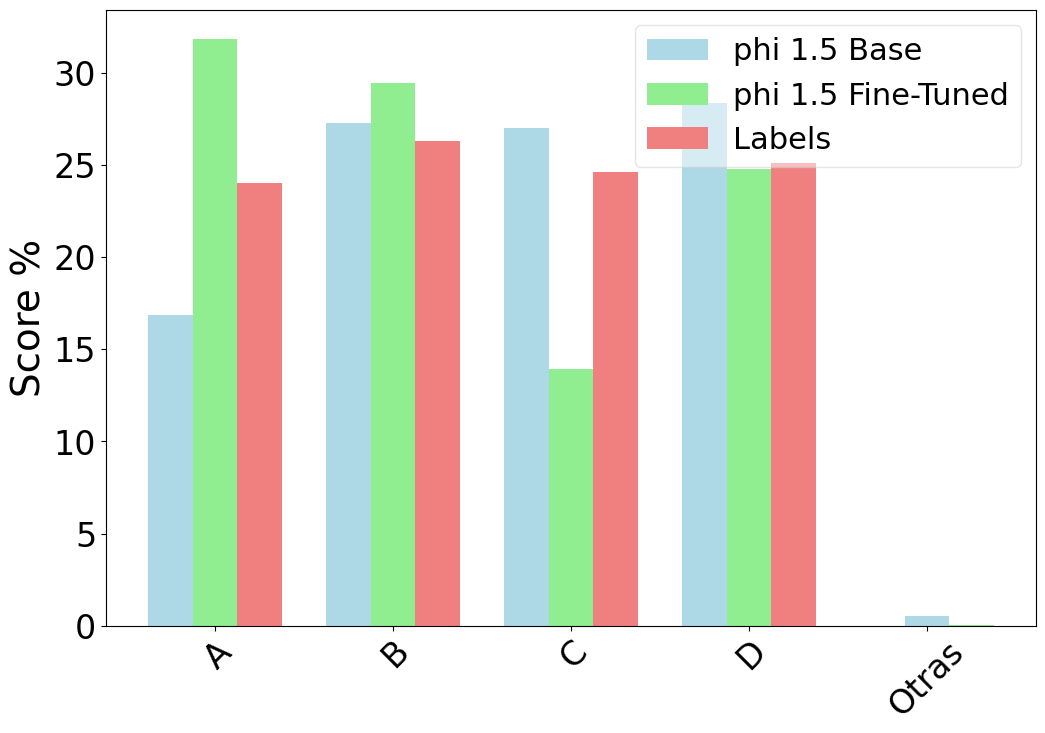

In [28]:

# Cargar las etiquetas de targets y logits del modelo base y ajustado
base_logits = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-1.5/hellaswag/Base/test_all_logits.npy')
base_targets = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-1.5/hellaswag/Base/test_all_targets.npy')

fine_tuned_logits = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-1.5/hellaswag/8/5/5000/1e-4/test_all_logits.npy')
fine_tuned_targets = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-1.5/hellaswag/8/5/5000/1e-4/test_all_targets.npy')
# Calcular la frecuencia de cada target en el modelo base
unique_base_targets, base_target_counts = np.unique(base_targets, return_counts=True)

scores_distribution(base_logits, base_targets, fine_tuned_logits, fine_tuned_targets,"hellaswag", "phi 1.5")


## Phi 1.5 SocialIQA

{' A': 32.92307692307692, ' B': 33.43589743589744, ' C': 33.64102564102564}
Base Targets Decoded: [' C', ' B', ' B', ' A', ' C', ' A', ' A', ' A', ' A', ' C', ' B', ' A', ' A', ' B', ' B', ' B', ' B', ' B', ' C', ' C', ' C', ' A', ' B', ' A', ' A', ' C', ' B', ' C', ' B', ' A', ' A', ' B', ' B', ' B', ' B', ' B', ' B', ' A', ' B', ' B', ' C', ' B', ' B', ' C', ' B', ' B', ' A', ' A', ' C', ' C', ' A', ' B', ' A', ' C', ' A', ' C', ' B', ' B', ' B', ' A', ' B', ' B', ' B', ' B', ' B', ' A', ' C', ' C', ' A', ' A', ' A', ' C', ' A', ' A', ' A', ' A', ' C', ' C', ' C', ' C', ' B', ' B', ' B', ' A', ' B', ' C', ' C', ' A', ' C', ' A', ' C', ' A', ' C', ' A', ' A', ' C', ' C', ' A', ' B', ' A', ' B', ' A', ' C', ' B', ' C', ' B', ' C', ' A', ' A', ' B', ' C', ' A', ' B', ' B', ' A', ' A', ' A', ' A', ' A', ' A', ' B', ' C', ' B', ' C', ' B', ' A', ' B', ' B', ' A', ' A', ' B', ' A', ' A', ' A', ' C', ' A', ' B', ' C', ' C', ' A', ' C', ' C', ' B', ' A', ' C', ' B', ' B', ' A', ' B', ' C', '

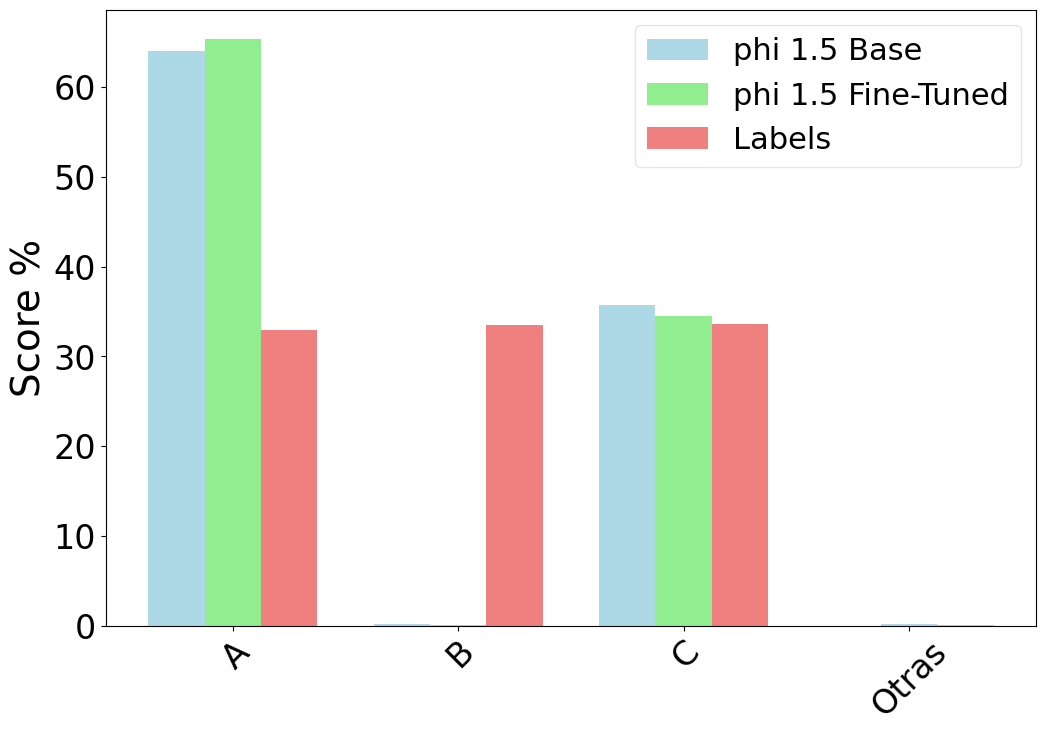

In [29]:

# Cargar las etiquetas de targets y logits del modelo base y ajustado
base_logits = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-1.5/socialiqa/Base/5000/test_all_logits.npy')
base_targets = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-1.5/socialiqa/Base/5000/test_all_targets.npy')

fine_tuned_logits = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-1.5/socialiqa/8/4/5000/1e-5/test_all_logits.npy')
fine_tuned_targets = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-1.5/socialiqa/8/4/5000/1e-5/test_all_targets.npy')

# Calcular la frecuencia de cada target en el modelo base
unique_base_targets, base_target_counts = np.unique(base_targets, return_counts=True)

scores_distribution(base_logits, base_targets, fine_tuned_logits, fine_tuned_targets,"socialiqa", "phi 1.5")


### Phi 2 SocialIQA

{' A': 32.92307692307692, ' B': 33.43589743589744, ' C': 33.64102564102564}
Base Targets Decoded: [' C', ' B', ' B', ' A', ' C', ' A', ' A', ' A', ' A', ' C', ' B', ' A', ' A', ' B', ' B', ' B', ' B', ' B', ' C', ' C', ' C', ' A', ' B', ' A', ' A', ' C', ' B', ' C', ' B', ' A', ' A', ' B', ' B', ' B', ' B', ' B', ' B', ' A', ' B', ' B', ' C', ' B', ' B', ' C', ' B', ' B', ' A', ' A', ' C', ' C', ' A', ' B', ' A', ' C', ' A', ' C', ' B', ' B', ' B', ' A', ' B', ' B', ' B', ' B', ' B', ' A', ' C', ' C', ' A', ' A', ' A', ' C', ' A', ' A', ' A', ' A', ' C', ' C', ' C', ' C', ' B', ' B', ' B', ' A', ' B', ' C', ' C', ' A', ' C', ' A', ' C', ' A', ' C', ' A', ' A', ' C', ' C', ' A', ' B', ' A', ' B', ' A', ' C', ' B', ' C', ' B', ' C', ' A', ' A', ' B', ' C', ' A', ' B', ' B', ' A', ' A', ' A', ' A', ' A', ' A', ' B', ' C', ' B', ' C', ' B', ' A', ' B', ' B', ' A', ' A', ' B', ' A', ' A', ' A', ' C', ' A', ' B', ' C', ' C', ' A', ' C', ' C', ' B', ' A', ' C', ' B', ' B', ' A', ' B', ' C', '

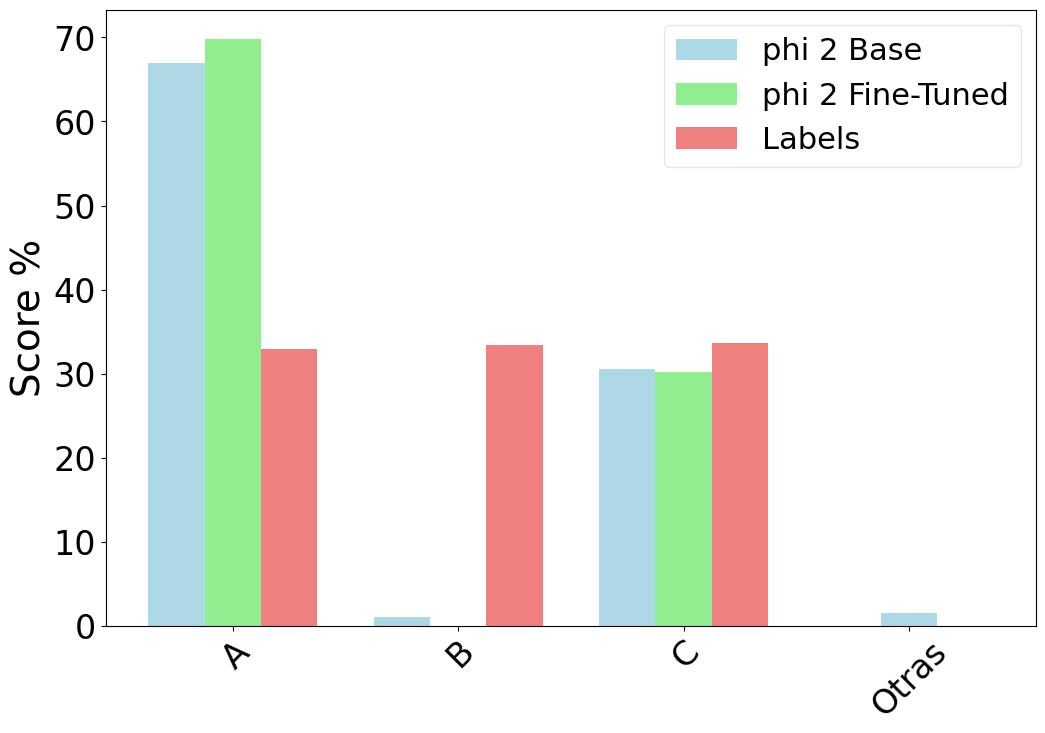

In [30]:

# Cargar las etiquetas de targets y logits del modelo base y ajustado
base_logits = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/socialiqa/Base/test_all_logits.npy')
base_targets = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/socialiqa/Base/test_all_targets.npy')

fine_tuned_logits = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/socialiqa/16/5/5000/1e-5/test_all_logits.npy')
fine_tuned_targets = np.load('/Users/juantollo/Documents/Tesis/experimentos/output/microsoft/phi-2/socialiqa/16/5/5000/1e-5/test_all_targets.npy')

# Calcular la frecuencia de cada target en el modelo base
unique_base_targets, base_target_counts = np.unique(base_targets, return_counts=True)

scores_distribution(base_logits, base_targets, fine_tuned_logits, fine_tuned_targets,"socialiqa", "phi 2")